# Valence・Arousal別々に回帰するモデル  　 

## データ読み込み

* オートエンコーダを使用  
* x軸 (Valence)：0~57  
→ 1→58次元
* y軸 (Arousal)：58~99  
→ 1→42次元

In [8]:
import os
import torch

print(torch.cuda.is_available())
os.environ['CUDA_VISIBLE_DEVICES'] = '2' # ←　使えない。なぜ?

True


In [2]:
print(torch.cuda.device_count())

4


### データから**座標値**と**音楽属性値**を取り出す

In [9]:
# EMOPIAデータセット
import pandas as pd
df_coor_attri = pd.read_csv('./xydata_attribute.csv')
coordinate = df_coor_attri['xy_data'].values
arrtibute = df_coor_attri['Attribute'].values

In [10]:
# 閾値関連
import torch.nn.functional as F
import numpy as np
import torch as th
# #音楽属性値の0,1の値を決める関数
def binarize_command(command, thresholds):
        discrete_feature = []
        for k in range(command.shape[0]):
            thres = thresholds[k]
            discrete_feature.append(np.float32(np.searchsorted(thres, command[k])))
        return discrete_feature
thresholds = np.load("../../../../../../data/threshold.npy", allow_pickle=True) #閾値
feature_index = np.load("../../../../../../data/feature_index.npy", allow_pickle=True) #特徴量100
thresholds_weight0 = th.load('../../../../../../../emogen/std_mean.pt') # 音楽属性値を揃える重み
thresholds_weight = th.where(thresholds_weight0[0,:] == 0.0, (th.tensor(0.0).float()), ((1.0 / thresholds_weight0[0,:]).float())).to('cpu').detach().numpy().copy() 

In [11]:
# 処理に必要な関数
import ast
# 文字列を数字に
# 座標値・音楽属性値を同時に取得
def str_to_float(list_str_coordinate , list_str_attribute):
    list_str_coordinate = np.array(list_str_coordinate)
    list_str_attribute = np.array(list_str_attribute)
    #print(t0)
    list_float_coordinate = np.zeros((0,2))
    list_float_attribute = np.zeros((0,1496))
    
    for t in list_str_coordinate:
        t = np.array(ast.literal_eval(t))
        list_float_coordinate = np.append(list_float_coordinate,t)
    for tt in list_str_attribute:
        tt = np.array(ast.literal_eval(tt))
        list_float_attribute  = np.append(list_float_attribute,tt)
        
    #print(t)
    list_float_coordinate = list_float_coordinate.reshape(len(list_str_coordinate), 2)
    list_float_attribute = list_float_attribute.reshape(len(list_str_attribute), 1496)
    return list_float_coordinate , list_float_attribute

* 正しいデータのみ取り出す！

In [12]:
# EMOPIA_clsの結果と一致しているデータのみ
True_filenumber_V_A = np.load('True_filenumber_V_A.npz')
Valence_correct_coordinate , Valence_correct_attribute = str_to_float(coordinate[True_filenumber_V_A['arr_0']] , arrtibute[True_filenumber_V_A['arr_0']]) 
Arousal_correct_coordinate , Arousal_correct_attribute = str_to_float(coordinate[True_filenumber_V_A['arr_1']] , arrtibute[True_filenumber_V_A['arr_1']]) 


1. 「0,1」の2値に変換

In [8]:
# 音楽属性値を0,1の値に変換
correnct_attribute_Arousal_100_01 = []
correnct_attribute_Valence_100_01 = []

# Valence
for k ,t_k in enumerate(Valence_correct_attribute):
    binary_command = binarize_command(Valence_correct_attribute[k][feature_index], thresholds)
    correnct_attribute_Valence_100_01.append(binary_command)
correnct_attribute_Valence_100_01 = np.squeeze(np.array(correnct_attribute_Valence_100_01))
# Arousal
for k ,t_k in enumerate(Arousal_correct_attribute):
    binary_command = binarize_command(Arousal_correct_attribute[k][feature_index], thresholds)
    correnct_attribute_Arousal_100_01.append(binary_command)
correnct_attribute_Arousal_100_01 = np.squeeze(np.array(correnct_attribute_Arousal_100_01))

print(type(correnct_attribute_Arousal_100_01[0,0]))

<class 'numpy.float32'>


以下は、各音楽属性が1(=属性が音楽内に存在する)」となる音楽の合計値  
→ High,Lowの平均個数の「差」  
→ **数字が大きいもの**を、重要な音楽属性値として採用したい  
↓↓ 

Valenceの場合 
* ピッチ：0~15  
* メロディー：16~29  
* コード：30~57

In [13]:
# High推定値とLow推定値の差_Valence
V_HLdiff_1 = [0.04611397, 0.14380582, 0.26974187, 0.17674337, 0.0288116,  0.28387797,
 0.,        0.,         0.00215054, 0.0758082,  0.0344086,  0.,
 0.00215054, 0.,         0.,         0.,         0.,         0.07271199,
 0.07996217, 0.,         0.13881826, 0.02312353, 0.12103254, 0.07144408,
 0.00215054, 0.10344997, 0.16544429, 0.01480158, 0.,         0.00215054,
 0.,         0.00436412, 0.09717348, 0.00430108, 0.00485447, 0.10446569,
 0.00853911, 0.10776505, 0.0748275,  0.08200764, 0.16579454, 0.276922,
 0.12827572, 0.23141746, 0.18071521, 0.19614725, 0.,         0.06145494,
 0.03460474, 0.20585619, 0.06344436, 0.,         0.00215054, 0.00430108,
 0.01714126, 0.04705965, 0.04604392, 0.1076249]

print([i for i, x in enumerate(V_HLdiff_1) if x >= 0.10])
Valence_feature_index = [i for i, x in enumerate(V_HLdiff_1) if x >= 0.10] # 重要な要素の番号

[1, 2, 3, 5, 20, 22, 25, 26, 35, 37, 40, 41, 42, 43, 44, 45, 49, 57]


Arousalの場合
* リズム：58~93  
* リズム関連(テンポ・ダイナミクス)：94,95  
* テクスチャー：96,97  
* ダイナミクス：98,99

In [14]:
# High推定値とLow推定値の差_Arousal
A_HLdiff_1 = [0.00000000e+00, 1.99203187e-03, 9.72267514e-02, 7.10609519e-02,
 2.85534021e-01, 4.25607180e-01, 3.54921949e-01, 9.55608172e-02,
 3.60692461e-02, 1.74554451e-01, 2.88894245e-01, 3.29146049e-01,
 3.58948547e-01, 4.16263771e-01, 1.71555770e-02, 2.30395145e-01,
 5.50608952e-02, 1.05854163e-01, 6.19656605e-02, 1.93361784e-01,
 9.80916193e-02, 7.07490323e-03, 0.00000000e+00, 2.38334917e-01,
 0.00000000e+00, 1.99203187e-03, 2.44084162e-01, 3.01080376e-01,
 4.40940863e-03, 2.78026683e-01, 6.80977159e-02, 4.19319165e-02,
 1.99203187e-03, 1.99203187e-03, 1.08994626e-01, 0.00000000e+00,
 0.00000000e+00, 6.25937531e-01, 1.99203187e-03, 2.12672442e-04,
 1.99203187e-03, 2.99761807e-01]

print([i+58 for i, x in enumerate(A_HLdiff_1) if x >= 0.10])
Arousal_feature_index = [i for i, x in enumerate(A_HLdiff_1) if x >= 0.10] # 重要な要素の番号

[62, 63, 64, 67, 68, 69, 70, 71, 73, 75, 77, 81, 84, 85, 87, 92, 95, 99]


<+わかったこと>  
→ Arousalの99番目の要素以外、閾値の値の**大きさ**(元々の音楽属性の大きさ)が1より小さい！！

# ------------------------------------

## 2段階予測  
1. 1次元(V/A) → **AutoEncoder**の中間層(1次元)  
2. 予測した**AutoEncoder**の中間層(1次元) → V/A値に対応する音楽属性値(18次元)

### (1. AutoEncoderの学習) 

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
#from torchinfo import summary

torch.manual_seed(0) #乱数の固定

x = torch.tensor(correnct_attribute_Valence_100_01[:,:58]) #入力値　※labelデータは無し(xがlabelになる)

AutoE = nn.Sequential(
    nn.Linear(58, 1), #入力3次元、出力2次元の全結合層
    nn.ReLU(inplace=True), #活性化関数
    nn.Linear(1, 58), #入力2次元、出力1次元の全結合層
)

print(f'初期値| x:{x}, pred:{AutoE(x)}') # label:{label}, 
print(f'x.shape:{x.shape},  pred.shape:{AutoE(x).shape}') # label.shape:{label.shape},
#print(summary(AutoE, input_size=(1, 3)))

lr = 0.01
criterion = nn.MSELoss() #損失関数:平均二乗誤差
optimizer = optim.Adam(AutoE.parameters(), lr=lr) #最適化手法:Adam
AutoE, x = AutoE.to("cuda:2"), x.to("cuda:2") #モデルと入力をCPUに移動
# "cuda" if torch.cuda.is_available() else "cpu"

for epoch in range(1000):
    optimizer.zero_grad() #勾配の初期化
    y = AutoE(x) #順伝播
    loss = criterion(y, x) #損失の計算　※label=x
    loss.backward() #誤差逆伝播
    optimizer.step() #パラメータの更新
    if epoch % 100 == 0:
        print(f'epoch: {epoch}, loss: {loss:.3f}')

初期値| x:tensor([[1., 0., 0.,  ..., 1., 0., 0.],
        [0., 1., 1.,  ..., 1., 0., 0.],
        [0., 1., 0.,  ..., 1., 0., 0.],
        ...,
        [0., 1., 1.,  ..., 1., 0., 0.],
        [0., 1., 0.,  ..., 1., 0., 0.],
        [0., 1., 0.,  ..., 1., 0., 0.]]), pred:tensor([[ 0.0451,  0.1459,  0.2372,  ...,  0.9030,  0.3622, -0.9025],
        [ 0.0451,  0.1459,  0.2372,  ...,  0.9030,  0.3622, -0.9025],
        [ 0.0451,  0.1459,  0.2372,  ...,  0.9030,  0.3622, -0.9025],
        ...,
        [ 0.0451,  0.1459,  0.2372,  ...,  0.9030,  0.3622, -0.9025],
        [ 0.0451,  0.1459,  0.2372,  ...,  0.9030,  0.3622, -0.9025],
        [ 0.0451,  0.1459,  0.2372,  ...,  0.9030,  0.3622, -0.9025]],
       grad_fn=<AddmmBackward>)
x.shape:torch.Size([772, 58]),  pred.shape:torch.Size([772, 58])
epoch: 0, loss: 0.842
epoch: 100, loss: 0.202
epoch: 200, loss: 0.114
epoch: 300, loss: 0.103
epoch: 400, loss: 0.102
epoch: 500, loss: 0.102
epoch: 600, loss: 0.102
epoch: 700, loss: 0.102
epoch: 800, 

### 1. AutoEncoderの学習 

In [8]:
import random

import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms


def set_random_seed(seed):
    """シード値を設定する"""
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


def computing_device(force=None):
    """環境によって計算に使うデバイスを切り替える関数"""
    if force is not None:
        return force
    if torch.cuda.is_available():
        return "cuda:2,3"
    if torch.backends.mps.is_available():
        return "mps"
    return "cpu"


class AutoEncoder_Valence(nn.Module):
    """ AutoEncoder モデル"""

    def __init__(self):
        super(AutoEncoder_Valence, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(
                in_features=len(Valence_feature_index),
                out_features=16,
            ),
            nn.LeakyReLU(inplace=True),#nn.ReLU(inplace=True),
            #nn.functional.leaky_relu(input=th.zeros()), # nn.ReLU(inplace=True), # 閾値処理だと負の値が出てくるため
            #nn.Linear(
            #    in_features=16,
            #    out_features=8,
            #),
            nn.Linear(
                in_features=16,
                out_features=8,
            ),
            nn.LeakyReLU(inplace=True), #nn.ReLU(inplace=True),
            nn.Linear(
                in_features=8,
                out_features=4,
            ),
            nn.LeakyReLU(inplace=True),
            #nn.functional.leaky_relu(input=th.zeros()), ## nn.ReLU(inplace=True),
            nn.Linear(
                in_features=4,
                out_features=1,
            ),
        )
        self.decoder = nn.Sequential(
            nn.Linear(
                in_features=1,
                out_features=4,
            ),
            #nn.ReLU(inplace=True),
            #nn.Linear(
            #    in_features=2,
            #    out_features=4,
            #),
            nn.LeakyReLU(inplace=True),
            #nn.functional.leaky_relu(input=th.zeros()), ## nn.ReLU(inplace=True),
            nn.Linear(
                in_features=4,
                out_features=8,
            ),
            nn.LeakyReLU(inplace=True), #nn.ReLU(inplace=True),
            nn.Linear(
                in_features=8,
                out_features=16,
            ),
            nn.LeakyReLU(inplace=True),
            #nn.functional.leaky_relu(input=th.zeros()), ## nn.ReLU(inplace=True),
            nn.Linear(
                in_features=16,
                out_features=len(Valence_feature_index),
            ),
            #nn.Softmax(),#nn.Sigmoid(),
        )

    def encode(self, x):
        """エンコードの処理をするメソッド"""
        return self.encoder(x)

    def forward(self, x):
        """順伝播"""
        x = self.encode(x)
        x = self.decoder(x)
        return x
    
    def decode(self, x):
        """デコード処理"""
        x = self.decoder(x)
        return x

class AutoEncoder_Arousal(nn.Module):
    """ AutoEncoder モデル"""

    def __init__(self):
        super(AutoEncoder_Arousal, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(
                in_features=len(Arousal_feature_index),
                out_features=16,
            ),
            nn.LeakyReLU(inplace=True), #nn.ReLU(inplace=True),
            nn.Linear(
                in_features=16,
                out_features=8,
            ),
            nn.LeakyReLU(inplace=True), #nn.ReLU(inplace=True),
            nn.Linear(
                in_features=8,
                out_features=4,
            ),
            nn.LeakyReLU(inplace=True), #nn.ReLU(inplace=True),
            nn.Linear(
                in_features=4,
                out_features=1,
            )
        )
        self.decoder = nn.Sequential(
            nn.Linear(
                in_features=1,
                out_features=4,
            ),
            nn.LeakyReLU(inplace=True), #nn.ReLU(inplace=True),
            nn.Linear(
                in_features=4,
                out_features=8,
            ),
            nn.LeakyReLU(inplace=True), #nn.ReLU(inplace=True),
            nn.Linear(
                in_features=8,
                out_features=16,
            ),
            nn.LeakyReLU(inplace=True), #nn.ReLU(inplace=True),
            nn.Linear(
                in_features=16,
                out_features=len(Arousal_feature_index),
            )
            #nn.Sigmoid(),
        )

    def encode(self, x):
        """エンコードの処理をするメソッド"""
        return self.encoder(x)

    def forward(self, x):
        """順伝播"""
        x = self.encode(x)
        x = self.decoder(x)
        return x
    def decode(self, x):
        """デコード処理"""
        x = self.decoder(x)
        return x
    

def evaluate(model, dataloader, device, criterion):
    """評価に使う関数"""
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for data in dataloader:
            # ラベルは使用しない
            inputs = data
            inputs = inputs.to(device)

            outputs = model(inputs)

            loss = criterion(outputs, inputs)
            running_loss += loss.item()

    average_loss = running_loss / len(dataloader)

    return average_loss


def train(
    model,
    train_dataloader,
    valid_dataloader,
    device,
    criterion,
    optimizer,
    num_epochs,
    early_stopping_patience,
    checkpoint_path="checkpoint.pt",
):
    """学習に使う関数"""
    print(f"Device: {device}")

    # Early Stopping に使うカウンタ
    early_stopping_patience_counter = 0
    # Early Stopping に使う検証データに対する損失
    early_stopping_best_val_loss = float("inf")

    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss = 0.0
        for batch_idx, data in enumerate(train_dataloader):
            # ラベルは使用しない
            inputs = data

            inputs = inputs.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch [{epoch}/{num_epochs}], Training Loss: {running_loss / len(train_dataloader):.5f}")

        val_loss = evaluate(model, valid_dataloader, device, criterion)
        print(f"Epoch [{epoch}/{num_epochs}], Validation Loss: {val_loss:.5f}")

        if early_stopping_patience == -1:
            continue

        if val_loss < early_stopping_best_val_loss:
            early_stopping_best_val_loss = val_loss
            early_stopping_patience_counter = 0
            # ベストなモデルとして Checkpoint を更新する
            checkpoint_params = {
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "loss": val_loss,
            }
            torch.save(
                checkpoint_params,
                checkpoint_path,
            )
        else:
            early_stopping_patience_counter += 1

        if early_stopping_patience_counter >= early_stopping_patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break

    print("Training Finished")


### 1. Valenceの予測

In [10]:
def main_valence():
    # 事前にシード値を固定する
    set_random_seed(42)

    # 学習用のデータセットを学習用と検証用に分割する
    dataset_size_Valence = len(np.float32((Valence_correct_attribute[:,feature_index])[:,Valence_feature_index])) #correnct_attribute_Valence_100_01[:,:58])
    thresholds_rep= np.float32((thresholds.repeat(dataset_size_Valence,1).T)) # 閾値を引く！
    val_size_Valence = int(dataset_size_Valence * 0.2)
    train_size_Valence = dataset_size_Valence - val_size_Valence
    train_dataset_Valence, valid_dataset_Valence = random_split(
        np.float32((Valence_correct_attribute[:,feature_index])[:,Valence_feature_index]) - thresholds_rep[:,Valence_feature_index], (train_size_Valence, val_size_Valence) # correnct_attribute_Valence_100_01[:,:58]
    )

    # データローダを設定する
    batch_size = 16
    train_dataloader_Valence = DataLoader(
        train_dataset_Valence,
        batch_size=batch_size,
        shuffle=True,
    )
    valid_dataloader_Valence = DataLoader(
        valid_dataset_Valence,
        batch_size=batch_size,
        shuffle=False,
    )
    test_dataloader_Valence = DataLoader(
        np.float32((Valence_correct_attribute[:,feature_index])[:,Valence_feature_index]) - thresholds_rep[:,Valence_feature_index], # correnct_attribute_Valence_100_01[:,:58], # 正確なValenceのデータ全て
        batch_size=batch_size,
        shuffle=False,
    )

    # 最大エポック数
    num_epochs = 1_000
    # 改善が見られなかった場合に停止する Early Stopping のエポック数
    early_stopping_patience = 100

    # 学習に使うデバイス
    device = computing_device()

    # モデル
    model_Valence = AutoEncoder_Valence()
    model_Valence = model_Valence.to(device)

    # 損失関数
    criterion = nn.MSELoss()
    # オプティマイザ
    optimizer_Valence = optim.Adam(model_Valence.parameters())

    # 途中結果を記録するパス
    checkpoint_path_Valence = "Valence_checkpoint.pt"
    
    # 学習する
    train(
        model_Valence,
        train_dataloader_Valence,
        valid_dataloader_Valence,
        device,
        criterion,
        optimizer_Valence,
        num_epochs,
        early_stopping_patience,
        checkpoint_path_Valence,
    )

        # ベストなモデルをロードする
    checkpoint_Valence = torch.load(checkpoint_path_Valence)
    model_Valence.load_state_dict(checkpoint_Valence["model_state_dict"])
    best_epoch_Valence = checkpoint_Valence["epoch"]
    best_val_loss_Valence = checkpoint_Valence["loss"]

    # テストデータを評価する
    test_loss_Valence = evaluate(
        model_Valence,
        test_dataloader_Valence,
        device,
        criterion,
    )
    print(f"Epoch: {best_epoch_Valence}, Validation Loss: {best_val_loss_Valence:.5f}")
    print(f"Test Set Evaluation - Loss: {test_loss_Valence:.5f}")


In [23]:
if __name__ == "__main__":
    main_valence()    

Device: cuda:2,3
Epoch [1/1000], Training Loss: 0.03052
Epoch [1/1000], Validation Loss: 0.01478
Epoch [2/1000], Training Loss: 0.00986
Epoch [2/1000], Validation Loss: 0.00704
Epoch [3/1000], Training Loss: 0.00667
Epoch [3/1000], Validation Loss: 0.00645
Epoch [4/1000], Training Loss: 0.00648
Epoch [4/1000], Validation Loss: 0.00643
Epoch [5/1000], Training Loss: 0.00648
Epoch [5/1000], Validation Loss: 0.00645
Epoch [6/1000], Training Loss: 0.00646
Epoch [6/1000], Validation Loss: 0.00643
Epoch [7/1000], Training Loss: 0.00649
Epoch [7/1000], Validation Loss: 0.00642
Epoch [8/1000], Training Loss: 0.00648
Epoch [8/1000], Validation Loss: 0.00643
Epoch [9/1000], Training Loss: 0.00649
Epoch [9/1000], Validation Loss: 0.00642
Epoch [10/1000], Training Loss: 0.00644
Epoch [10/1000], Validation Loss: 0.00641
Epoch [11/1000], Training Loss: 0.00646
Epoch [11/1000], Validation Loss: 0.00640
Epoch [12/1000], Training Loss: 0.00640
Epoch [12/1000], Validation Loss: 0.00634
Epoch [13/1000], 

* 学習済みモデルの読み込み

In [9]:
# コサイン類似度
import numpy as np

def cos_sim(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

In [24]:
import torch 
model_Valence = AutoEncoder_Valence()
model_Valence.load_state_dict(torch.load('Valence_checkpoint.pt')['model_state_dict'])

# モデルの評価
# Valenceの場合
dataset_size_Valence = len(np.float32((Valence_correct_attribute[:,feature_index])[:,Valence_feature_index])) #correnct_attribute_Valence_100_01[:,:58])
thresholds_rep= np.float32((thresholds.repeat(dataset_size_Valence,1).T)) 
# 閾値を用いる場合　↑↑
Valence_true = np.float32(Valence_correct_attribute[:,feature_index])[:,Valence_feature_index] - thresholds_rep[:,Valence_feature_index] # 真のデータ
Valence_decode = model_Valence(torch.tensor(Valence_true))
print(Valence_true.shape)
# cos類似度
Valence_decode_all  = 0.0
for i in range(len(Valence_true)):
    Valence_decode_all0 = cos_sim(np.squeeze(Valence_true[i]), np.squeeze(Valence_decode[i].detach().numpy())) # 256→100
    if np.isnan(Valence_decode_all0) ==  False: 
        Valence_decode_all = Valence_decode_all + Valence_decode_all0
print(Valence_decode_all / len(Valence_true))
print(Valence_decode[2])
print(Valence_true[2])
print(Valence_decode[3])

(772, 18)
0.8925881551414574
tensor([ 6.0883e-02, -1.1950e-02, -4.5097e-02, -1.2382e-02,  1.7882e-03,
         3.0358e-04,  1.4120e-01,  1.0574e-02,  8.2507e-03,  2.0943e-03,
         1.2728e-03, -9.2539e-05, -1.0604e-03,  3.8284e-03,  1.0869e-04,
         3.8297e-04, -4.9048e-02, -1.7534e-01], grad_fn=<SelectBackward>)
[ 0.131825   -0.06401     0.0373     -0.06954    -0.016848    0.
  0.2598     -0.01114     0.0138      0.011481    0.007978    0.001612
 -0.001597    0.00688     0.002453    0.002368   -0.0816     -0.05975002]
tensor([ 0.0475,  0.0211, -0.0685,  0.0072, -0.0074,  0.0004, -0.1048, -0.0171,
         0.0033,  0.0045,  0.0044,  0.0063, -0.0013,  0.0131,  0.0020,  0.0025,
        -0.0305, -0.1151], grad_fn=<SelectBackward>)


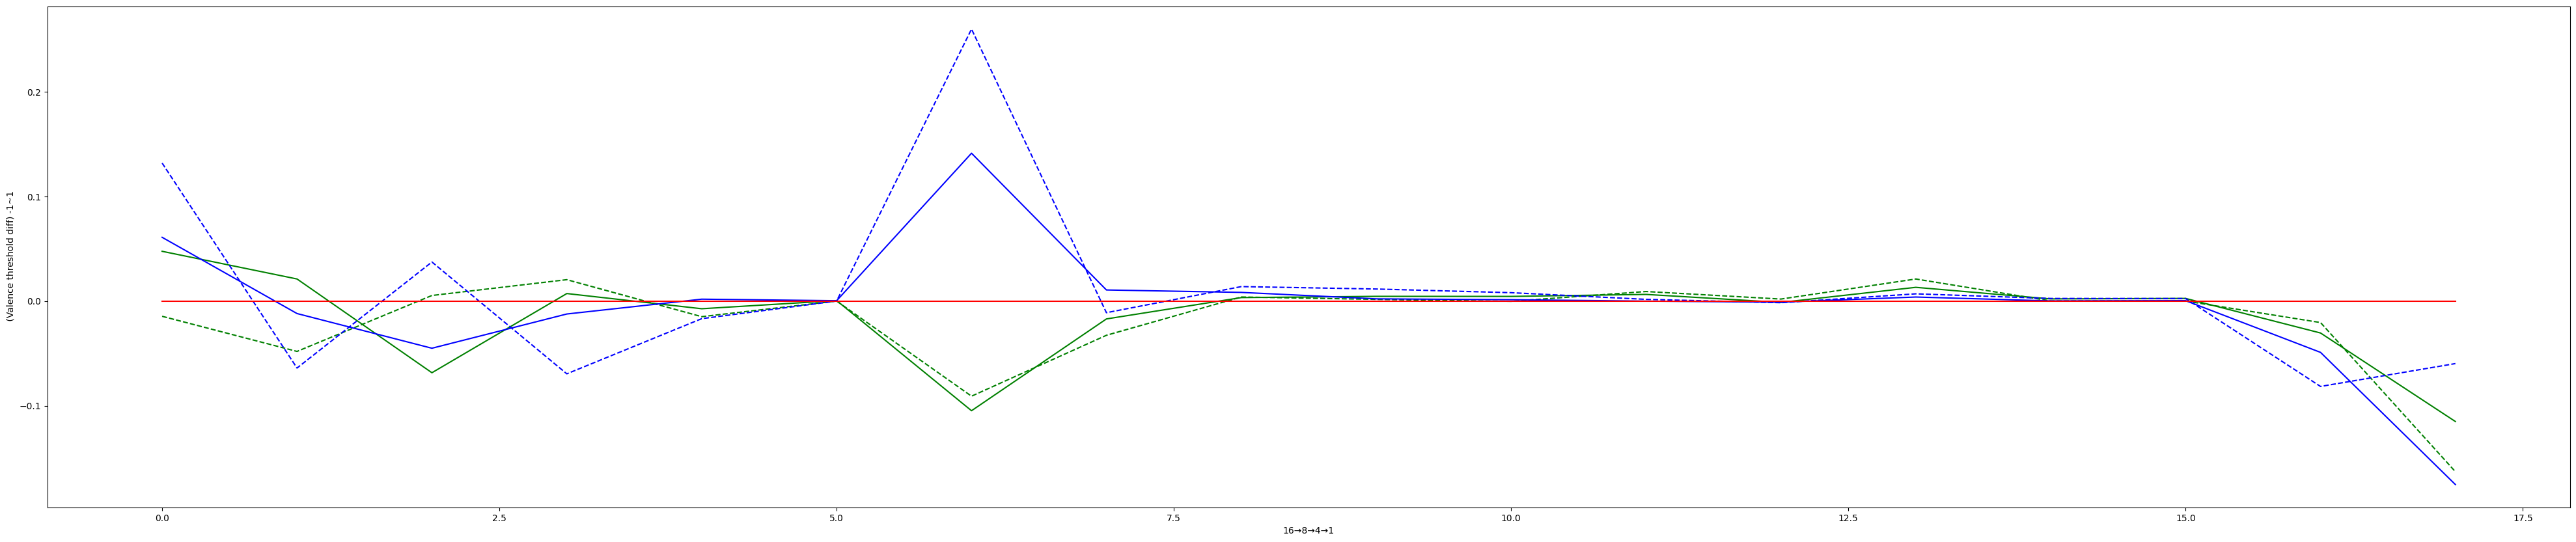

In [25]:
# 2つの出力結果の値について、正解値とどれぐらい乖離しているかを図で見た
from matplotlib import pyplot as  plt
plt.figure(figsize=(50,10))
plt.plot(Valence_decode[3].detach().numpy(),  color='green') # 4番目のデータ
plt.plot(Valence_true[3], ls="--", color='green') 
plt.plot(Valence_decode[2].detach().numpy(),  color='blue') # 3番目のデータ
plt.plot(Valence_true[2], ls="--",color='blue') # Q4 - Q3　(正の変化)
plt.plot(np.zeros(18),color='red')

#plt.plot(np.mean(Valence_decode[2].detach().numpy(), axis = 0) ,color='blue') # Q2 - Q1 (負の変化)  
#plt.plot(np.mean(Valence_true[2], axis = 0), ls="--",color='blue') # Q4 - Q3　(正の変化)
plt.xlabel('16→8→4→1')
plt.ylabel(' (Valence threshold diff) -1~1')
plt.show()


### 1. Arousalの予測

In [22]:
print((Arousal_correct_attribute[:,feature_index])[:,58:].shape)#[:,:].shape)

(1064, 42)


In [10]:
def main_arousal():
    # 事前にシード値を固定する
    set_random_seed(42)


    # 学習用のデータセットを学習用と検証用に分割する
    dataset_size_Arousal =  len(np.float32((Arousal_correct_attribute[:,feature_index])[:,Arousal_feature_index])) #correnct_attribute_Valence_100_01[:,:58])
    thresholds_rep= np.float32((thresholds.repeat(dataset_size_Arousal,1).T)) # 閾値を引く！
    val_size_Arousal = int(dataset_size_Arousal * 0.2)
    train_size_Arousal = dataset_size_Arousal - val_size_Arousal
    train_dataset_Arousal, valid_dataset_Arousal = random_split(
        np.float32((Arousal_correct_attribute[:,feature_index])[:,Arousal_feature_index]) - thresholds_rep[:,Arousal_feature_index], (train_size_Arousal, val_size_Arousal) #correnct_attribute_Arousal_100_01[:,58:]
    )

    # データローダを設定する
    batch_size = 16
    train_dataloader_Arousal = DataLoader(
        train_dataset_Arousal,
        batch_size=batch_size,
        shuffle=True,
    )
    valid_dataloader_Arousal = DataLoader(
        valid_dataset_Arousal,
        batch_size=batch_size,
        shuffle=False,
    )
    test_dataloader_Arousal = DataLoader(
        np.float32((Arousal_correct_attribute[:,feature_index])[:,Arousal_feature_index]) - thresholds_rep[:,Arousal_feature_index], #correnct_attribute_Arousal_100_01[:,58:], # 正確なArousalのデータ全て
        batch_size=batch_size,
        shuffle=False,
    )

    # 最大エポック数
    num_epochs = 1_000
    # 改善が見られなかった場合に停止する Early Stopping のエポック数
    early_stopping_patience = 5

    # 学習に使うデバイス
    device = computing_device()

    # モデル
    model_Arousal = AutoEncoder_Arousal()
    model_Arousal = model_Arousal.to(device)

    # 損失関数
    criterion = nn.MSELoss()
    # オプティマイザ
    optimizer_Arousal = optim.Adam(model_Arousal.parameters())

    # 途中結果を記録するパス
    checkpoint_path_Arousal = "Arousal_checkpoint.pt"
    
    # 学習する
    train(
        model_Arousal,
        train_dataloader_Arousal,
        valid_dataloader_Arousal,
        device,
        criterion,
        optimizer_Arousal,
        num_epochs,
        early_stopping_patience,
        checkpoint_path_Arousal,
    )

        # ベストなモデルをロードする
    checkpoint_Arousal = torch.load(checkpoint_path_Arousal)
    model_Arousal.load_state_dict(checkpoint_Arousal["model_state_dict"])
    best_epoch_Arousal = checkpoint_Arousal["epoch"]
    best_val_loss_Arousal = checkpoint_Arousal["loss"]

    # テストデータを評価する
    test_loss_Arousal = evaluate(
        model_Arousal,
        test_dataloader_Arousal,
        device,
        criterion,
    )
    print(f"Epoch: {best_epoch_Arousal}, Validation Loss: {best_val_loss_Arousal:.5f}")
    print(f"Test Set Evaluation - Loss: {test_loss_Arousal:.5f}")


In [25]:
if __name__ == "__main__":
    main_arousal()  

Device: cuda:2,3
Epoch [1/1000], Training Loss: 606.03529
Epoch [1/1000], Validation Loss: 594.33207
Epoch [2/1000], Training Loss: 497.61688
Epoch [2/1000], Validation Loss: 238.93794
Epoch [3/1000], Training Loss: 85.80611
Epoch [3/1000], Validation Loss: 14.56257
Epoch [4/1000], Training Loss: 5.56419
Epoch [4/1000], Validation Loss: 3.40294
Epoch [5/1000], Training Loss: 3.35960
Epoch [5/1000], Validation Loss: 3.42083
Epoch [6/1000], Training Loss: 3.32986
Epoch [6/1000], Validation Loss: 3.37188
Epoch [7/1000], Training Loss: 3.32141
Epoch [7/1000], Validation Loss: 3.34781
Epoch [8/1000], Training Loss: 3.35333
Epoch [8/1000], Validation Loss: 3.34819
Epoch [9/1000], Training Loss: 3.31889
Epoch [9/1000], Validation Loss: 3.34084
Epoch [10/1000], Training Loss: 3.25708
Epoch [10/1000], Validation Loss: 3.32824
Epoch [11/1000], Training Loss: 3.26437
Epoch [11/1000], Validation Loss: 3.33103
Epoch [12/1000], Training Loss: 3.28538
Epoch [12/1000], Validation Loss: 3.30850
Epoch [

* 学習済みモデルを読み込み

In [11]:
# コサイン類似度
import numpy as np

def cos_sim(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

In [26]:
import torch 
model_Arousal = AutoEncoder_Arousal()
model_Arousal.load_state_dict(torch.load('Arousal_checkpoint.pt')['model_state_dict'])

# モデルの評価
# Valenceの場合
dataset_size_Arousal = len(np.float32((Arousal_correct_attribute[:,feature_index])[:,Arousal_feature_index])) #correnct_attribute_Valence_100_01[:,:58])
thresholds_rep= np.float32((thresholds.repeat(dataset_size_Arousal,1).T)) 
# 閾値を用いる場合　↑↑
Arousal_true = np.float32(Arousal_correct_attribute[:,feature_index])[:,Arousal_feature_index] - thresholds_rep[:,Arousal_feature_index] # 真のデータ
Arousal_decode = model_Arousal(torch.tensor(Arousal_true))
print(Arousal_true.shape)
# cos類似度
Arousal_decode_all  = 0.0
for i in range(len(Arousal_true)):
    Arousal_decode_all0 = cos_sim(np.squeeze(Arousal_true[i]), np.squeeze(Arousal_decode[i].detach().numpy())) # 256→100
    if np.isnan(Arousal_decode_all0) ==  False: 
        Arousal_decode_all = Arousal_decode_all + Arousal_decode_all0
print(Arousal_decode_all / len(Arousal_true))
print(Arousal_decode[2])
print(Arousal_true[2])
print(Arousal_decode[3])

(1064, 18)
0.9973906834882901
tensor([ 1.5404e-01, -3.6005e-02, -2.7593e+01, -2.0470e-01,  2.9914e-01,
        -5.9288e+01,  5.5757e+01, -5.8049e+01,  3.2660e+00, -4.9836e-02,
        -1.0733e-01, -1.1152e-02, -4.0943e-03,  1.0708e+00,  1.4530e+01,
         4.6782e-04,  1.4577e-02, -7.5370e-03], grad_fn=<SelectBackward>)
[ 1.5266000e-01 -6.9540001e-02 -2.7500000e+01 -1.7140001e-01
  2.5295001e-01 -5.9000000e+01  5.6576500e+01 -5.6710999e+01
  2.1096499e+00 -8.4150005e-03 -1.1738300e-01  0.0000000e+00
 -1.1140004e-02  1.6215501e+00  1.7615499e+01 -7.8899991e-03
  1.1481000e-02  1.6120002e-03]
tensor([ 1.5481e-01, -3.6010e-02, -2.7718e+01, -2.0577e-01,  3.0042e-01,
        -5.9559e+01,  5.6012e+01, -5.8316e+01,  3.2814e+00, -4.9354e-02,
        -1.0775e-01, -1.0747e-02, -3.3709e-03,  1.0761e+00,  1.4596e+01,
         1.0923e-04,  1.4372e-02, -7.1542e-03], grad_fn=<SelectBackward>)


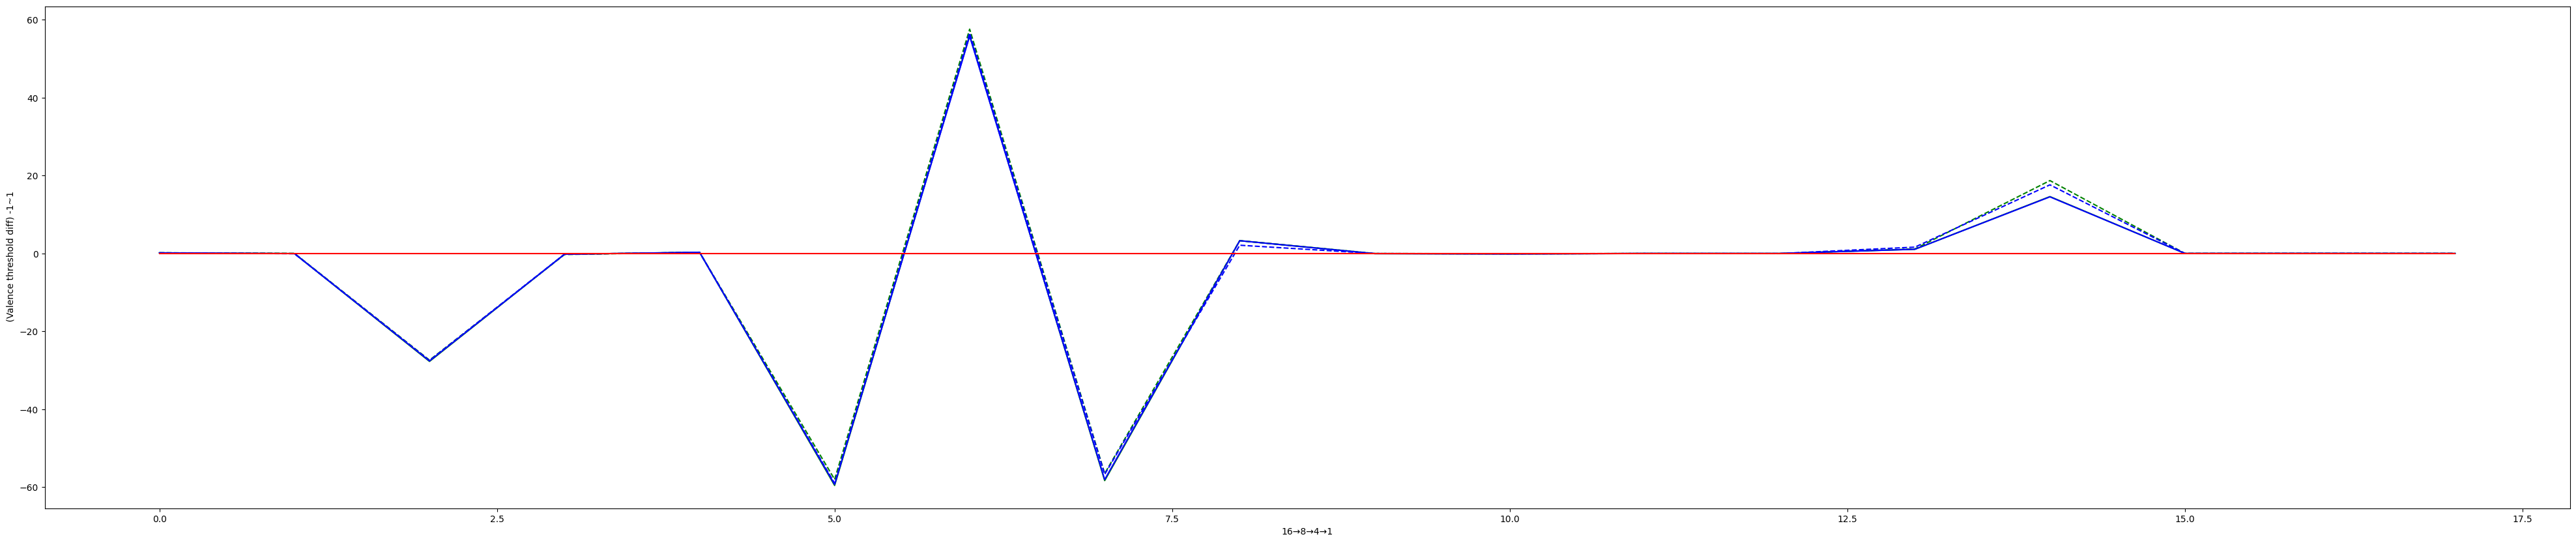

In [27]:
# 2つの出力結果の値について、正解値とどれぐらい乖離しているかを図で見た
from matplotlib import pyplot as  plt
plt.figure(figsize=(50,10))
plt.plot(Arousal_decode[3].detach().numpy(),  color='green') # 4番目のデータ
plt.plot(Arousal_true[3], ls="--", color='green') 
plt.plot(Arousal_decode[2].detach().numpy(),  color='blue')  # 3番目のデータ
plt.plot(Arousal_true[2], ls="--",color='blue') # Q4 - Q3　(正の変化)
plt.plot(np.zeros(18),color='red')#thresholds[Valence_feature_index],color='red')

#plt.plot(np.mean(Valence_decode[2].detach().numpy(), axis = 0) ,color='blue') # Q2 - Q1 (負の変化)  
#plt.plot(np.mean(Valence_true[2], axis = 0), ls="--",color='blue') # Q4 - Q3　(正の変化)
plt.xlabel('16→8→4→1')
plt.ylabel(' (Valence threshold diff) -1~1')
plt.show()


### 2.全てのデータの中間層の予測(一次元)を、学習済みモデルから取得
* AutoEncoder_Valence()
* AutoEncoder_Arousal()

### 2. Valenceの予測

In [ ]:
# 中間層の出力を取り出す
import torch 
model_Valence = AutoEncoder_Valence()
model_Valence.load_state_dict(torch.load('Valence_checkpoint.pt')['model_state_dict'])
Valence_encode = model_Valence.encode(torch.tensor(np.float32(Valence_correct_attribute[:,feature_index])[:,Valence_feature_index]))
#Valence_decode =  model_Valence.decode(Valence_encode)


In [13]:
print((np.float32(Valence_correct_coordinate[:,0])).shape)
print(np.squeeze(np.float32(Valence_encode.detach().numpy())).shape)

(772,)
(772,)


* 一次元(x座標)　→ 1次元(凝縮された音楽属性値)　データの分布を調べる

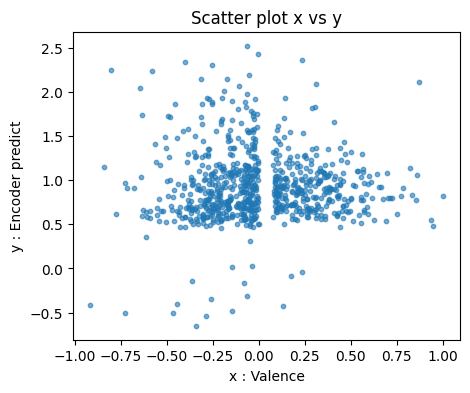

Pearson r: 0.004541501555648347 p: 0.8997467318150072
Spearman rho: 0.058924812500519994 p: 0.10184208080678589
Mutual information estimate: 0.05017120232291994


/home/moyu/.conda/envs/music/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/moyu/.conda/envs/music/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/moyu/.conda/envs/music/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/moyu/.conda/envs/music/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expec

CV R2 scores: [-0.38171393 -0.57475742 -0.28312054 -0.43123908 -0.14522322] mean R2: -0.36321083514222446


/home/moyu/.conda/envs/music/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/moyu/.conda/envs/music/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/moyu/.conda/envs/music/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/moyu/.conda/envs/music/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was exp

Original R2: 0.8145641724754079 Permutation mean R2: 0.7991478901533475 p-value: 0.06


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.feature_selection import mutual_info_regression
from scipy.stats import pearsonr, spearmanr
from sklearn.utils import shuffle


x_true_Valence = (np.float32(Valence_correct_coordinate[:,0]))#.reshape(-1, 1)
y_true_Valence = np.squeeze(np.float32(Valence_encode.detach().numpy()))#.reshape(-1, 1)

# ---- 1. 可視化 ----
plt.figure(figsize=(5,4))
plt.scatter(x_true_Valence.reshape(-1, 1), y_true_Valence.reshape(-1, 1), s=10, alpha=0.6)
plt.xlabel("x : Valence")
plt.ylabel("y : Encoder predict")
plt.title("Scatter plot x vs y")
plt.show()

# ---- 2. 相関係数 ----
# .ravel()
pearson_r, pearson_p = pearsonr(x_true_Valence, y_true_Valence)
spearman_r, spearman_p = spearmanr(x_true_Valence, y_true_Valence)
print("Pearson r:", pearson_r, "p:", pearson_p)
# Pearson r: 0.004541501555648347 p: 0.8997467318150072
print("Spearman rho:", spearman_r, "p:", spearman_p)
# Spearman rho: 0.058924812500519994 p: 0.10184208080678589

# ---- 3. 相互情報量（非線形依存の検出） ----
mi = mutual_info_regression(x_true_Valence.reshape(-1, 1), y_true_Valence.reshape(-1, 1), random_state=0)
print("Mutual information estimate:", mi[0])
# Mutual information estimate: 0.05017120232291994

# ---- 4. 回帰ベースの説明力（交差検証でのR^2） ----
model_RFR = RandomForestRegressor(random_state=0, n_estimators=100)
cv = KFold(n_splits=5, shuffle=True, random_state=0)
scores = cross_val_score(model_RFR, x_true_Valence.reshape(-1, 1), y_true_Valence.reshape(-1, 1), scoring='r2', cv=cv)
print("CV R2 scores:", scores, "mean R2:", np.mean(scores))
# CV R2 scores: [-0.38171393 -0.57475742 -0.28312054 -0.43123908 -0.14522322] mean R2: -0.36321083514222446

# ---- 5. 置換テスト（入力シャッフルしてR2の差を確かめる） ----
model_RFR .fit(x_true_Valence.reshape(-1, 1), y_true_Valence.reshape(-1, 1))
y_pred_Valence = model_RFR.predict(x_true_Valence.reshape(-1, 1))
orig_r2 = r2_score(y_true_Valence.reshape(-1, 1),y_pred_Valence)

n_perm = 100
perm_r2 = []
for i in range(n_perm):
    x_sh = shuffle(x_true_Valence.reshape(-1, 1), random_state=i)
    model_sh = RandomForestRegressor(random_state=0, n_estimators=100).fit(x_sh,y_true_Valence.reshape(-1, 1))
    perm_r2.append(r2_score(y_true_Valence.reshape(-1, 1), model_sh.predict(x_sh)))

perm_r2 = np.array(perm_r2)
p_value = np.mean(perm_r2 >= orig_r2)
print("Original R2:", orig_r2, "Permutation mean R2:", perm_r2.mean(), "p-value:", p_value)
# Original R2: 0.8145641724754079 Permutation mean R2: 0.7991478901533475 p-value: 0.06

1. sklearnの回帰モデル

In [12]:
# 学習用・テスト用データに分割 
from sklearn.model_selection import train_test_split
# モデルの定義、ハイパーパラメータの値を設定
from sklearn.linear_model import Ridge , LinearRegression
ridge = Ridge(alpha=0.01)
from sklearn.kernel_ridge import KernelRidge
clf = KernelRidge(alpha=1.0, kernel='rbf')


In [18]:
# 座標-エンコーダ予測 のモデル
Vc = (np.float32(Valence_correct_coordinate[:,0])).reshape(-1, 1)
Va_1 = np.squeeze(np.float32(Valence_encode.detach().numpy())).reshape(-1, 1)
Vc_train, Vc_test, Va_1_train, Va_1_test = train_test_split((np.float32(Valence_correct_coordinate[:,0])).reshape(-1, 1), np.squeeze(np.float32(Valence_encode.detach().numpy())).reshape(-1, 1), test_size=0.2, random_state=0)

# Ridge回帰の場合
ridge.fit(Vc_train, Va_1_train)

# カーネルリッジ回帰
clf.fit(Vc, Va_1)

KernelRidge(alpha=1.0, kernel='rbf')

In [19]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

# SVR (RBFカーネル) を試す
pipe = Pipeline([('scaler', StandardScaler()), ('svr', SVR())])
param_grid = {'svr__C':[0.1,1,10], 'svr__gamma':['scale','auto'], 'svr__epsilon':[0.01,0.1,0.5]}
gs = GridSearchCV(pipe, param_grid, cv=5, scoring='r2', n_jobs=-1)
gs.fit(Vc, Va_1.ravel())
print("Best SVR R2:", gs.best_score_, gs.best_params_)
# Best SVR R2: -0.044279282616363644 {'svr__C': 0.1, 'svr__epsilon': 0.1, 'svr__gamma': 'auto'}

Best SVR R2: -0.044279282616363644 {'svr__C': 0.1, 'svr__epsilon': 0.1, 'svr__gamma': 'auto'}


2. ニューラルネットワーク (一次元→一次元)  
* 定義・学習

In [ ]:
import torch 
class SimpleMLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size * 2) 
        self.fc3 = nn.Linear(hidden_size * 2 , hidden_size)
        self.fc4 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU() # nn.LeakyReLU(0.01)
        self.fc5 = nn.Linear(hidden_size * 2, hidden_size * 4) 
        self.fc6 = nn.Linear(hidden_size * 4 , hidden_size * 2)
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        #x = self.relu(self.fc5(x))
        #x = self.relu(self.fc6(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x
    
# ニューラルネットワーク　多層パーセプトロン (MLP)

def train2(
    model,
    train_dataloader,
    valid_dataloader,
    device,
    criterion,
    optimizer,
    num_epochs,
    early_stopping_patience,
    checkpoint_path="checkpoint.pt",
):
    """学習に使う関数"""
    print(f"Device: {device}")

    # Early Stopping に使うカウンタ
    early_stopping_patience_counter = 0
    # Early Stopping に使う検証データに対する損失
    early_stopping_best_val_loss = float("inf")

    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss = 0.0
        for coordinate, attribute in train_dataloader:
            # ラベルは使用しない
            inputs = coordinate.to(device)
            true_output = attribute.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            loss = criterion(outputs, true_output)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch [{epoch}/{num_epochs}], Training Loss: {running_loss / len(train_dataloader):.5f}")

        val_loss = evaluate2(model, valid_dataloader, device, criterion)
        print(f"Epoch [{epoch}/{num_epochs}], Validation Loss: {val_loss:.5f}")

        if early_stopping_patience == -1:
            continue

        if val_loss < early_stopping_best_val_loss:
            early_stopping_best_val_loss = val_loss
            early_stopping_patience_counter = 0
            # ベストなモデルとして Checkpoint を更新する
            checkpoint_params = {
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "loss": val_loss,
            }
            torch.save(
                checkpoint_params,
                checkpoint_path,
            )
        else:
            early_stopping_patience_counter += 1

        if early_stopping_patience_counter >= early_stopping_patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break

    print("Training Finished")
    
 
def evaluate2(model, dataloader, device, criterion):
    """評価に使う関数"""
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for coordinate, attribute in dataloader:
            inputs = coordinate.to(device)
            true_output = attribute.to(device)

            outputs = model(inputs)

            loss = criterion(outputs, true_output)
            running_loss += loss.item()

    average_loss = running_loss / len(dataloader)

    return average_loss   
from torch.utils.data import TensorDataset, DataLoader
## 学習-----------

set_random_seed(42) # 事前にシード値を固定する

# 学習用のデータセット 
Vc = np.float32(Valence_correct_coordinate[:,0])#.reshape(-1, 1)
Va_1 = np.squeeze(np.float32(Valence_encode.detach().numpy()))#.reshape(-1, 1)

#Vc_size =  len(Vc)
#val_Vc_size = int(Vc_size * 0.2)
#train_Vc_size = Vc_size - val_Vc_size
train_Vc , valid_Vc , train_Va_1 , valid_Va_1= train_test_split(Vc,Va_1,test_size=0.2, random_state=0)

# データローダ
batch_size = 16
train_dataset = TensorDataset(th.from_numpy(train_Vc).unsqueeze(1), th.from_numpy(train_Va_1).unsqueeze(1))
valid_dataset = TensorDataset(th.from_numpy(valid_Vc).unsqueeze(1), th.from_numpy(valid_Va_1).unsqueeze(1))
test_dataset = TensorDataset(th.from_numpy(Vc).unsqueeze(1), th.from_numpy(Va_1).unsqueeze(1))
#print(test_dataset[1])
train_dataloader_V_c_a1 = DataLoader(train_dataset,batch_size=batch_size,shuffle=True,)
valid_dataloader_V_c_a1 = DataLoader(valid_dataset,batch_size=batch_size,shuffle=True,)
test_dataloader_V_c_a1 = DataLoader(test_dataset,batch_size=batch_size,shuffle=False,)


# 最大エポック数
num_epochs = 1_000
# 改善が見られなかった場合に停止する Early Stopping のエポック数
early_stopping_patience = 5

# 学習に使うデバイス
device = computing_device()

# モデル
# モデルのハイパーパラメータ
INPUT_SIZE = 1 # x : Valence
HIDDEN_SIZE = 32 # 隠れ層のユニット数（調整可能）
OUTPUT_SIZE = 1    # y : Encoder predict
model_V_c_a1 = SimpleMLP(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE).to(device)

# 損失関数
criterion = nn.MSELoss()
# オプティマイザ
optimizer_V_c_a1 = optim.Adam(model_V_c_a1.parameters()) # LEARNING_RATE = 0.001

# 途中結果を記録するパス
checkpoint_path_V_c_a1 = "Valence_c_a1_checkpoint.pt"
    
# 学習する
train2(
    model_V_c_a1,
    train_dataloader_V_c_a1,
    valid_dataloader_V_c_a1,
    device,
    criterion,
    optimizer_V_c_a1,
    num_epochs,
    early_stopping_patience,
    checkpoint_path_V_c_a1,
)

# ベストなモデルをロードする
checkpoint_V_c_a1 = torch.load(checkpoint_path_V_c_a1)
model_V_c_a1.load_state_dict(checkpoint_V_c_a1["model_state_dict"])
best_epoch_V_c_a1 = checkpoint_V_c_a1["epoch"]
best_val_loss_V_c_a1 = checkpoint_V_c_a1["loss"]

# テストデータを評価する
test_loss_V_c_a1 = evaluate2(
    model_V_c_a1,
    test_dataloader_V_c_a1,
    device,
    criterion,
)
print(f"Epoch: {best_epoch_V_c_a1}, Validation Loss: {best_val_loss_V_c_a1:.5f}")
print(f"Test Set Evaluation - Loss: {test_loss_V_c_a1:.5f}")
   

* ニューラルネットワークモデル評価  
→ 学習済みモデルを読み込み

In [ ]:
import torch 

INPUT_SIZE = 1 # x : Valence
HIDDEN_SIZE = 32 # 隠れ層のユニット数（調整可能）
OUTPUT_SIZE = 1 
class SimpleMLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size * 2) 
        self.fc3 = nn.Linear(hidden_size * 2 , hidden_size)
        self.fc4 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU() # nn.LeakyReLU(0.01)
        self.fc5 = nn.Linear(hidden_size * 2, hidden_size * 4) 
        self.fc6 = nn.Linear(hidden_size * 4 , hidden_size * 2)
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        #x = self.relu(self.fc5(x))
        #x = self.relu(self.fc6(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x
model_V_c_a1 = SimpleMLP(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE).to(device)
model_V_c_a1.load_state_dict(torch.load('Valence_c_a1_checkpoint.pt')['model_state_dict'])

In [27]:
print((np.float32(Valence_encode.detach().numpy())).reshape(-1, 1)[1])
print(predict_Valence_encode.reshape(-1, 1).cpu().detach().numpy()[1])

cos_sim(np.squeeze(np.float32(Valence_encode.detach().numpy())) , np.squeeze(predict_Valence_encode.reshape(-1, 1).cpu().detach().numpy()))

[0.8246946]
[0.89426875]


0.91673315

正解中間層データ[1.0074553]
予測中間層データtensor([0.8821], device='cuda:2', grad_fn=<SelectBackward>)
-------
正解中間層データ[0.8246946]
予測中間層データtensor([0.8902], device='cuda:2', grad_fn=<SelectBackward>)
-------
正解中間層データ[1.0788841]
予測中間層データtensor([0.9573], device='cuda:2', grad_fn=<SelectBackward>)
-------
正解中間層データ[0.9261405]
予測中間層データtensor([0.9185], device='cuda:2', grad_fn=<SelectBackward>)
-------
正解中間層データ[0.86811596]
予測中間層データtensor([0.9267], device='cuda:2', grad_fn=<SelectBackward>)
-------
正解中間層データ[0.6083392]
予測中間層データtensor([0.9015], device='cuda:2', grad_fn=<SelectBackward>)
-------
正解中間層データ[1.0316706]
予測中間層データtensor([0.9150], device='cuda:2', grad_fn=<SelectBackward>)
-------
正解中間層データ[0.6466918]
予測中間層データtensor([0.9180], device='cuda:2', grad_fn=<SelectBackward>)
-------
正解中間層データ[1.1936722]
予測中間層データtensor([0.9163], device='cuda:2', grad_fn=<SelectBackward>)
-------
正解中間層データ[0.86575323]
予測中間層データtensor([0.9271], device='cuda:2', grad_fn=<SelectBackward>)
-------
正解中間層データ[0.8727084]
予測中間層データtensor([0.

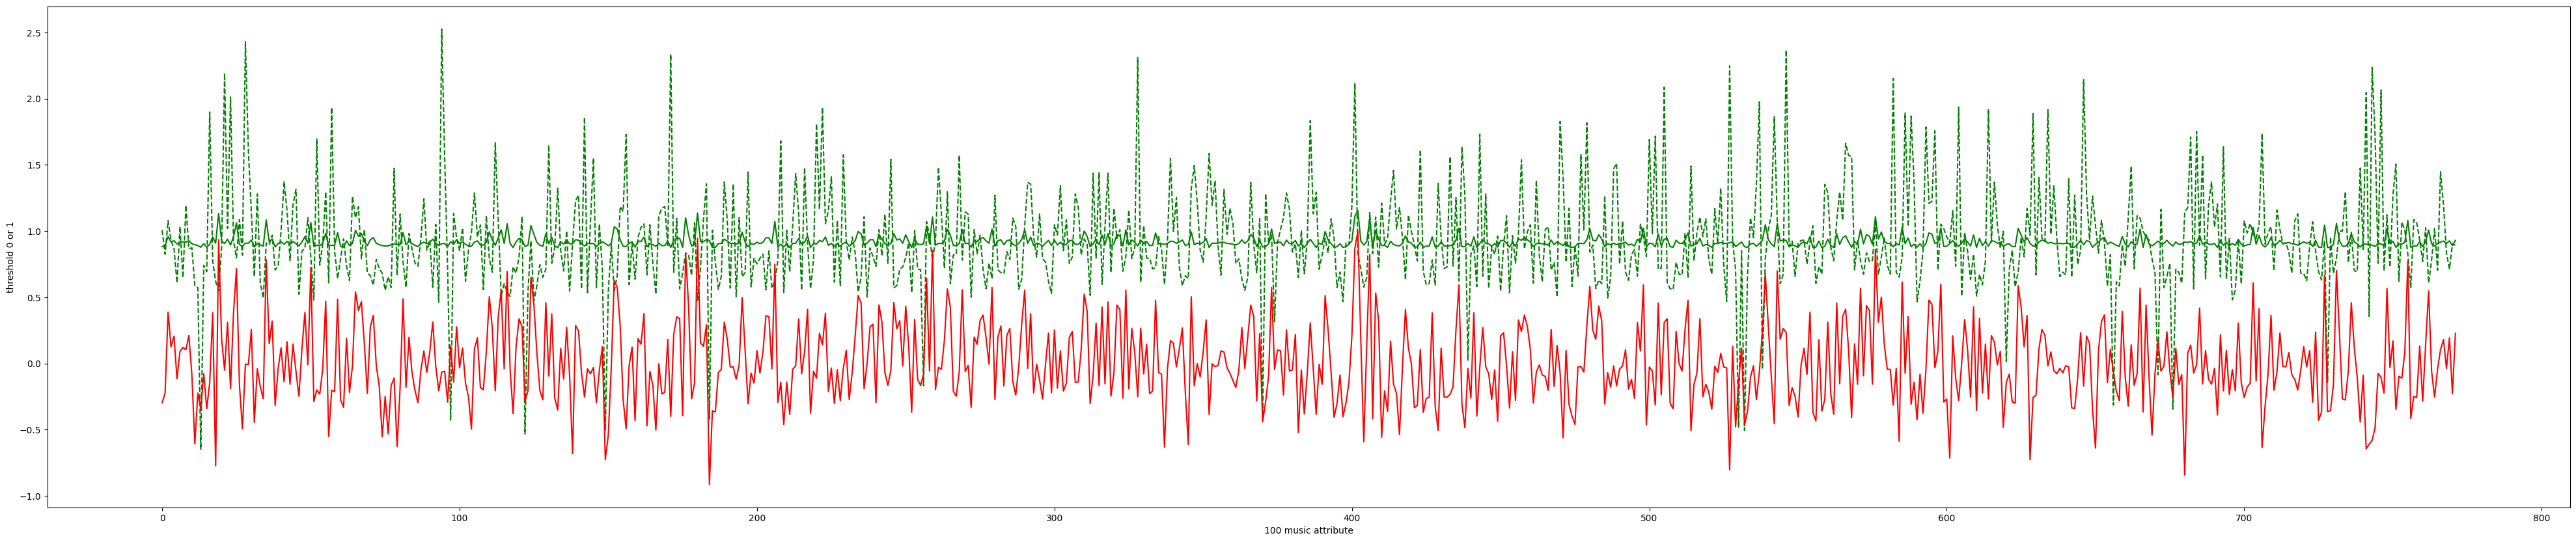

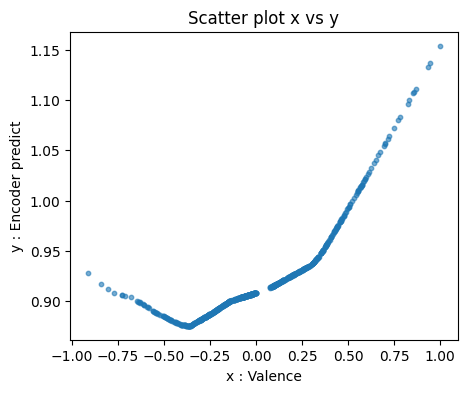

In [37]:
# リッジ回帰
#predict_Valence_encode = ridge.predict((np.float32(Valence_correct_coordinate[:,0])).reshape(-1, 1))
#score = ridge.score(Vc_test,Va_1_test)
# カーネルリッジ
#predict_Valence_encode = clf.predict((np.float32(Valence_correct_coordinate[:,0])).reshape(-1, 1))
#score = clf.score(Vc,Va_1)
# ニューラルネットワーク
predict_Valence_encode = (model_V_c_a1(th.from_numpy(Vc).to(torch.float32).unsqueeze(1).to(device))).reshape(-1, 1)

# -------------------
# cos類似度
Valence_c_a1_all  = 0.0
for i in range(772):
    Valence_c_a1_all0 = cos_sim((np.float32(Valence_encode.detach().numpy())).reshape(-1, 1)[i] , predict_Valence_encode.reshape(-1, 1).cpu().detach().numpy()[i])
    if np.isnan(Valence_c_a1_all0) ==  False: 
        Valence_c_a1_all = Valence_c_a1_all + Valence_c_a1_all0
    print("正解中間層データ" + str((np.float32(Valence_encode.detach().numpy())).reshape(-1, 1)[i]))
    print("予測中間層データ" + str(predict_Valence_encode[i]))
    print("-------")
#print(score)
print(Valence_c_a1_all / 772.0) #len(Valence_true))
print(cos_sim(np.squeeze(np.float32(Valence_encode.detach().numpy())) , np.squeeze(predict_Valence_encode.reshape(-1, 1).cpu().detach().numpy())))
# 隠れ層64(層増やす)：0.9637305699481865 Epoch: 9, Validation Loss: 0.14584 , Test Set Evaluation - Loss: 0.16209
# 隠れ層64：0.9637305699481865 Epoch: 8, Validation Loss: 0.14528 , Test Set Evaluation - Loss: 0.16222
# 隠れ層32：0.9637305699481865 Epoch: 19, Validation Loss: 0.14568 ,Test Set Evaluation - Loss: 0.16129
# 隠れ層4：0.9637305699481865 Epoch: 47, Validation Loss: 0.14854 , Test Set Evaluation - Loss: 0.16489

# -------------------
# ピアソン相関係数
from scipy.stats import pearsonr, spearmanr
pearson_r, pearson_p = pearsonr(np.squeeze(np.float32(Valence_encode.detach().numpy())), np.squeeze(np.float32(predict_Valence_encode.cpu().detach().numpy())))
spearman_r, spearman_p = spearmanr((np.float32(Valence_encode.detach().numpy())).reshape(-1, 1), (np.float32(predict_Valence_encode.reshape(-1, 1).cpu().detach().numpy())))
print("Pearson r:", pearson_r, "p:", pearson_p)
# 隠れ層4：Pearson r: -0.0005162119168185507 p: 0.9885749625469793
# 隠れ層32：Pearson r: -0.02229339712070657 p: 0.536250599138729
# 隠れ層64：Pearson r: -0.03857304596249752 p: 0.2844350249176255
# 隠れ層64(層増やす)：Pearson r: -0.027976730912104397 p: 0.43761750342679906
print("Spearman rho:", spearman_r, "p:", spearman_p)
# 隠れ層4： Spearman rho: 0.058924812500519994 p: 0.10184208080678589
# 隠れ層32： Spearman rho: 0.05766299676854676 p: 0.10939995780255374
# 隠れ層64： Spearman rho: 0.039388603070614765 p: 0.2743679984575537
# 隠れ層64(層増やす)：Spearman rho: 0.050044296240355675 p: 0.16480461770717889

# -------------------
# 可視化
from matplotlib import pyplot as  plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import numpy as np

#plt.figure(figsize=(50,10))
#plt.subplot(1,2,1)
#sc = StandardScaler() 
plt.figure(figsize=(50,10))
plt.plot((np.float32(Valence_encode.detach().numpy())).reshape(-1, 1),ls="--",  color="green") #sns.scatterplot(data = Q1_4average[0] , color="green")
plt.plot(predict_Valence_encode.reshape(-1, 1).cpu().detach().numpy(), color="green")
#plt.plot((np.float32(Valence_encode.detach().numpy())).reshape(-1, 1) - predict_Valence_encode.reshape(-1, 1).cpu().detach().numpy(), color="red")
plt.plot((np.float32(Valence_correct_coordinate[:,0])).reshape(-1, 1) , color="red")
plt.xlabel('100 music attribute')
plt.ylabel('threshold 0 or 1')
plt.show()

# ---- 1. 可視化 ----
x_true_Valence = (np.float32(Valence_correct_coordinate[:,0]))#.reshape(-1, 1)
y_true_Valence = np.squeeze(np.float32(Valence_encode.detach().numpy()))#.reshape(-1, 1)
plt.figure(figsize=(5,4))
plt.scatter(x_true_Valence.reshape(-1, 1), predict_Valence_encode.reshape(-1, 1).cpu().detach().numpy(), s=10, alpha=0.6)
plt.xlabel("x : Valence")
plt.ylabel("y : Encoder predict")
plt.title("Scatter plot x vs y")
plt.show()

3. 確率的回帰モデル  
3-1. Quantile Regression で分布範囲を確認  
→ 各xでの下限・中央値・上限の推定線  
* 赤線(中央値)：トレンド  
* 緑線(上下線)：不確実性... $x=0$周辺で感覚が大きいと「ばらつきが大きい」

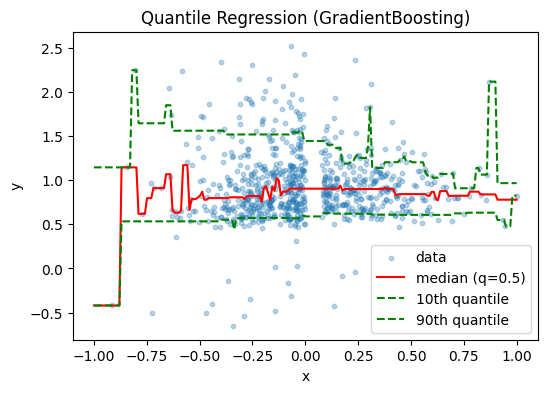

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor

# --- 例: データ読み込み ---
# x: shape (n_samples, 1), y: shape (n_samples,)
x_true_Valence = (np.float32(Valence_correct_coordinate[:,0])).reshape(-1, 1) #  x座標値
y_true_Valence = np.squeeze(np.float32(Valence_encode.detach().numpy()))#.reshape(-1, 1) # 一次元の音楽属性値


# --- 分位点設定 ---
quantiles = [0.1, 0.5, 0.9]
models = {}

# --- モデル学習 ---
for q in quantiles:
    gbr = GradientBoostingRegressor(loss='quantile', alpha=q, n_estimators=300, max_depth=3, random_state=0)
    gbr.fit(x_true_Valence, y_true_Valence)
    models[q] = gbr

# --- 予測と可視化 ---
x_test = np.linspace(-1, 1, 200).reshape(-1, 1)
y_pred = np.column_stack([models[q].predict(x_test) for q in quantiles])

plt.figure(figsize=(6,4))
plt.scatter(x_true_Valence, y_true_Valence, s=10, alpha=0.3, label='data')
plt.plot(x_test, y_pred[:,1], 'r-', label='median (q=0.5)')
plt.plot(x_test, y_pred[:,0], 'g--', label='10th quantile')
plt.plot(x_test, y_pred[:,2], 'g--', label='90th quantile')
plt.title("Quantile Regression (GradientBoosting)")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()


3-2.Mixture Density Network (MDN)  
「一つのxに対して複数のガウス分布確率分布（複数の平均・分散・重み）」を出力」

Epoch 0, loss = 1.6133
Epoch 500, loss = 0.2391
Epoch 1000, loss = 0.2117
Epoch 1500, loss = 0.1945
Epoch 2000, loss = 0.1688
Epoch 2500, loss = 0.1660


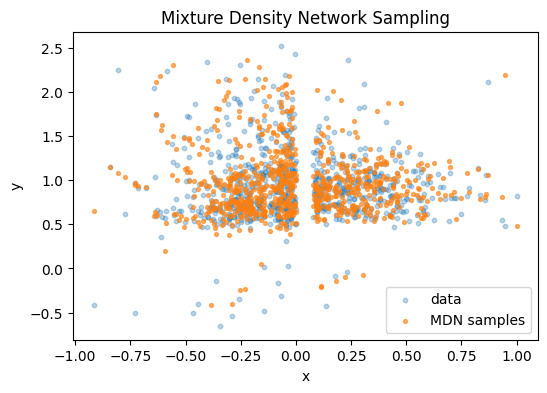

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# numpy -> torch
X = torch.tensor(x_true_Valence.astype(np.float32))
Y = torch.tensor(y_true_Valence.reshape(-1, 1).astype(np.float32))

class MDN(nn.Module):
    def __init__(self, in_dim=1, hidden=64, n_components=5):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden), nn.ReLU(),
            nn.Linear(hidden, hidden), nn.ReLU()
        )
        self.pi = nn.Linear(hidden, n_components)
        self.mu = nn.Linear(hidden, n_components)
        self.log_sigma = nn.Linear(hidden, n_components)
    def forward(self, x):
        h = self.net(x)
        pi = torch.softmax(self.pi(h), dim=1)
        mu = self.mu(h)
        sigma = torch.exp(self.log_sigma(h)) + 1e-6
        return pi, mu, sigma

def mdn_loss(pi, mu, sigma, y):
    m = torch.distributions.Normal(mu, sigma)
    log_probs = m.log_prob(y.expand_as(mu))
    weighted = log_probs + torch.log(pi + 1e-12)
    log_sum = torch.logsumexp(weighted, dim=1)
    return -log_sum.mean()

# 学習
model = MDN()
opt = optim.Adam(model.parameters(), lr=1e-3)
for epoch in range(3000):
    pi, mu, sigma = model(X)
    loss = mdn_loss(pi, mu, sigma, Y)
    opt.zero_grad(); loss.backward(); opt.step()
    if epoch % 500 == 0:
        print(f"Epoch {epoch}, loss = {loss.item():.4f}")

# サンプリング
with torch.no_grad():
    x_test = X #
    # x_test = torch.linspace(-1, 1, 200).unsqueeze(1)
    pi, mu, sigma = model(x_test)
    comp = torch.multinomial(pi, 1).squeeze()
    idx = torch.arange(len(comp))
    y_sample = mu[idx, comp] + sigma[idx, comp] * torch.randn(len(comp)) #

# 可視化
plt.figure(figsize=(6,4))
plt.scatter(x_true_Valence, y_true_Valence, s=10, alpha=0.3, label='data')
# plt.scatter(x_test, y_sample, s=8, alpha=0.6, label='MDN samples')
plt.scatter(x_true_Valence, y_sample, s=8, alpha=0.6, label='MDN samples')
plt.title("Mixture Density Network Sampling")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

* 評価

/tmp/ipykernel_2819399/3203769414.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  xy_true_plot.append(np.array([x_true_Valence[i],y_true_Valence[i]]))
/tmp/ipykernel_2819399/3203769414.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  xy_predict_plot.append(np.array([x_true_Valence[i],y_predict_Valence[i]]))


正解中間層データ[array([-0.29766116], dtype=float32) 1.0074553]
予測中間層データ[array([-0.29766116], dtype=float32) 0.99784505]
cos類似度[0.9999966]
-------
正解中間層データ[array([-0.22399868], dtype=float32) 0.8246946]
予測中間層データ[array([-0.22399868], dtype=float32) 0.9030714]
cos類似度[0.9997562]
-------
正解中間層データ[array([0.38721552], dtype=float32) 1.0788841]
予測中間層データ[array([0.38721552], dtype=float32) 1.1817071]
cos類似度[0.9996099]
-------
正解中間層データ[array([0.12553503], dtype=float32) 0.9261405]
予測中間層データ[array([0.12553503], dtype=float32) 0.9548353]
cos類似度[0.999992]
-------
正解中間層データ[array([0.2061308], dtype=float32) 0.86811596]
予測中間層データ[array([0.2061308], dtype=float32) 1.1400946]
cos類似度[0.9985284]
-------
正解中間層データ[array([-0.11630385], dtype=float32) 0.6083392]
予測中間層データ[array([-0.11630385], dtype=float32) 1.0793687]
cos類似度[0.9966754]
-------
正解中間層データ[array([0.09104145], dtype=float32) 1.0316706]
予測中間層データ[array([0.09104145], dtype=float32) 1.4312562]
cos類似度[0.9996999]
-------
正解中間層データ[array([0.12063462], dtype=float32)

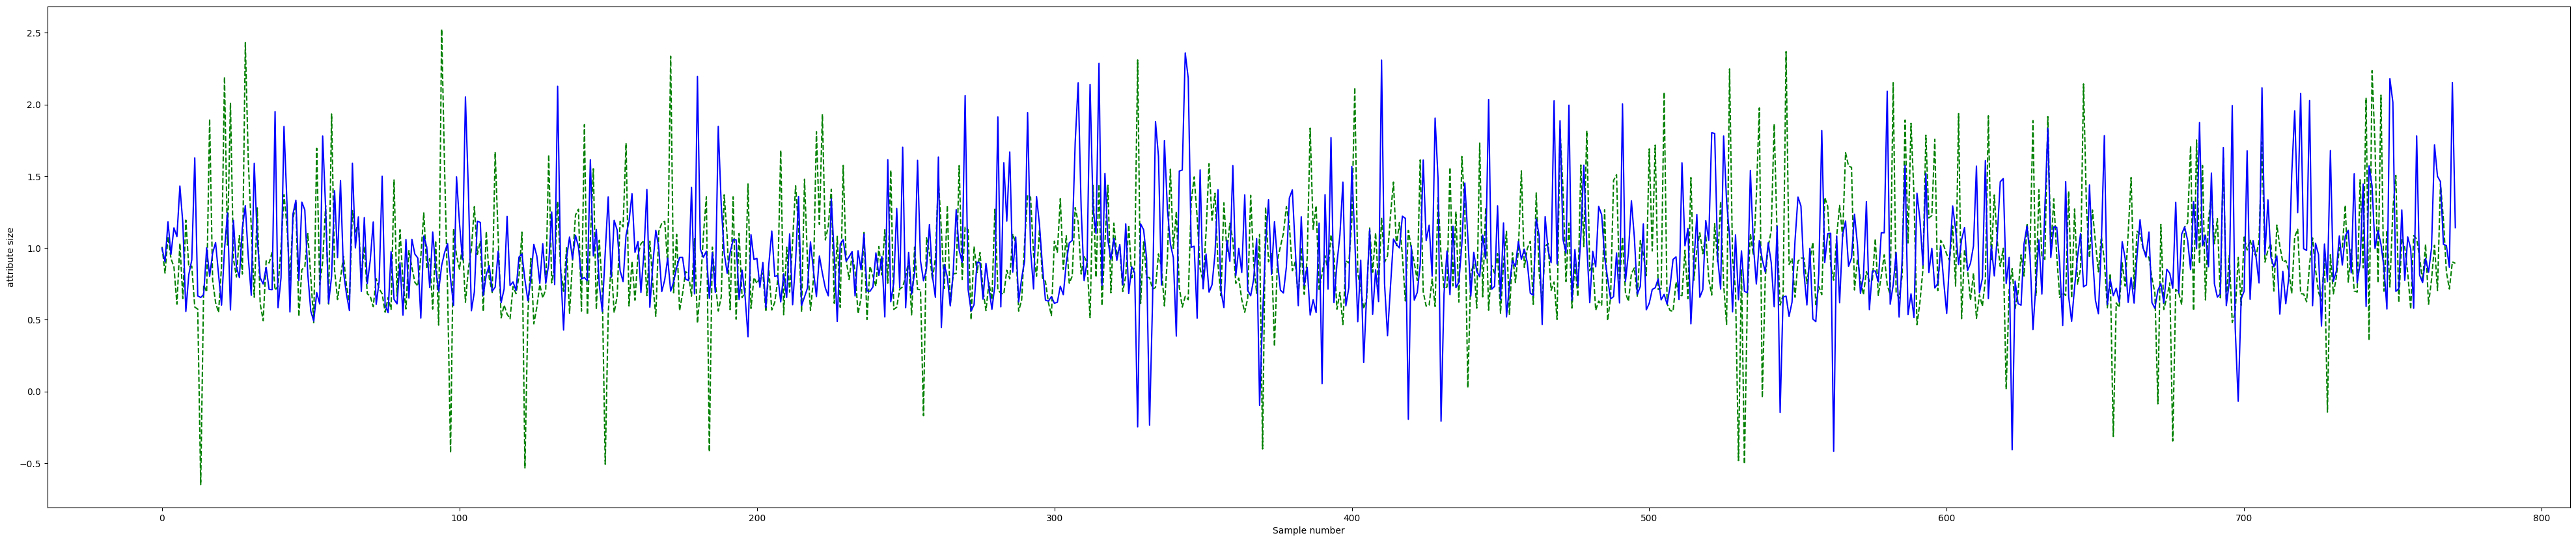

'\nx_true_Valence = (np.float32(Valence_correct_coordinate[:,0]))#.reshape(-1, 1)\ny_true_Valence = np.squeeze(np.float32(Valence_encode.detach().numpy()))#.reshape(-1, 1)\nplt.figure(figsize=(5,4))\nplt.scatter(x_true_Valence.reshape(-1, 1), predict_Valence_encode.reshape(-1, 1).cpu().detach().numpy(), s=10, alpha=0.6)\nplt.xlabel("x : Valence")\nplt.ylabel("y : Encoder predict")\nplt.title("Scatter plot x vs y")\nplt.show()\n'

In [17]:
# -------------------
# cos類似度
# x_true_Valence = (np.float32(Valence_correct_coordinate[:,0])).reshape(-1, 1) #  x座標値
# y_true_Valence = np.squeeze(np.float32(Valence_encode.detach().numpy()))#
y_predict_Valence = np.squeeze(y_sample.cpu().detach().numpy())
#print(y_predict_Valence)
#print(y_true_Valence)
xy_true_plot=[]
xy_predict_plot=[]
for i in range(772):  #2次元の定義(入力,出力)
    xy_true_plot.append(np.array([x_true_Valence[i],y_true_Valence[i]]))
    xy_predict_plot.append(np.array([x_true_Valence[i],y_predict_Valence[i]]))
# 一つずつ個別に'''
Valence_c_a1_all  = 0.0
for j in range(772):
    Valence_c_a1_all0 = cos_sim(np.array(xy_true_plot)[j] , np.array(xy_predict_plot)[j])
    if np.isnan(Valence_c_a1_all0) ==  False: 
        Valence_c_a1_all = Valence_c_a1_all + Valence_c_a1_all0
    print("正解中間層データ" + str(np.array(xy_true_plot)[j]))
    print("予測中間層データ" + str(np.array(xy_predict_plot)[j]))
    print("cos類似度" + str(Valence_c_a1_all0))
    print("-------")
print(Valence_c_a1_all / 772.0) #len(Valence_true))
#'''
# 全ての値をまとめて類似度を見る
print(cos_sim(y_true_Valence, y_predict_Valence))
print(cos_sim(np.array(xy_true_plot).T, np.array(xy_predict_plot)))
# -------------------
# ピアソン相関係数
from scipy.stats import pearsonr, spearmanr
pearson_r, pearson_p = pearsonr(y_true_Valence, np.squeeze(y_sample.cpu().detach().numpy()))
spearman_r, spearman_p = spearmanr(y_true_Valence, np.squeeze(y_sample.cpu().detach().numpy()))
print("Pearson r:", pearson_r, "p:", pearson_p)
print("Spearman rho:", spearman_r, "p:", spearman_p)

# -------------------
# 可視化
from matplotlib import pyplot as  plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import numpy as np


plt.figure(figsize=(50,10))
plt.plot((y_true_Valence).reshape(-1, 1),ls="--",  color="green") #sns.scatterplot(data = Q1_4average[0] , color="green")
plt.plot(y_predict_Valence, color="blue")
#plt.plot((np.float32(Valence_encode.detach().numpy())).reshape(-1, 1) - predict_Valence_encode.reshape(-1, 1).cpu().detach().numpy(), color="red")
#plt.plot((np.float32(Valence_correct_coordinate[:,0])).reshape(-1, 1) , color="red")
plt.xlabel('Sample number')
plt.ylabel('attribute size')
plt.show()

# ---- 1. 可視化 ----
'''
x_true_Valence = (np.float32(Valence_correct_coordinate[:,0]))#.reshape(-1, 1)
y_true_Valence = np.squeeze(np.float32(Valence_encode.detach().numpy()))#.reshape(-1, 1)
plt.figure(figsize=(5,4))
plt.scatter(x_true_Valence.reshape(-1, 1), predict_Valence_encode.reshape(-1, 1).cpu().detach().numpy(), s=10, alpha=0.6)
plt.xlabel("x : Valence")
plt.ylabel("y : Encoder predict")
plt.title("Scatter plot x vs y")
plt.show()
'''

In [ ]:
# cos類似度
# Valenceの場合
dataset_size_Valence = len(np.float32((Valence_correct_attribute[:,feature_index])[:,Valence_feature_index])) #correnct_attribute_Valence_100_01[:,:58])
thresholds_rep= np.float32((thresholds.repeat(dataset_size_Valence,1).T)) 
# 閾値を用いる場合　↑↑
Valence_true = np.float32(Valence_correct_attribute[:,feature_index])[:,Valence_feature_index] - thresholds_rep[:,Valence_feature_index] # 真のデータ
Valence_decode = model_Valence(torch.tensor(Valence_true))
print(Valence_true.shape)
# cos類似度
Valence_decode_all  = 0.0
for i in range(len(Valence_true)):
    Valence_decode_all0 = cos_sim(np.squeeze(Valence_true[i]), np.squeeze(Valence_decode[i].detach().numpy())) # 256→100
    if np.isnan(Valence_decode_all0) ==  False: 
        Valence_decode_all = Valence_decode_all + Valence_decode_all0
print(Valence_decode_all / len(Valence_true))
print(Valence_decode[2])
print(Valence_true[2])
print(Valence_decode[3])

### 2. Arousalの予測  
→ Valenceの精度が低いため断念

In [ ]:
# 中間層の出力を取り出す
import torch 
model_Arousal = AutoEncoder_Arousal()
model_Arousal.load_state_dict(torch.load('Arousal_checkpoint.pt')['model_state_dict'])
Arousal_encode = model_Arousal.encode(torch.tensor(np.float32(Valence_correct_attribute[:,feature_index])[:,Valence_feature_index]))
#Arousal_decode =  model_Arousal.decode(Arousal_encode)

## 1次元 →18次元を直接予測

### 関数等の定義 (ニューラルネットワーク)

In [15]:
import random

import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

In [16]:
def computing_device(force=None):
    """環境によって計算に使うデバイスを切り替える関数"""
    if force is not None:
        return force
    if torch.cuda.is_available():
        return "cuda:2,3"
    if torch.backends.mps.is_available():
        return "mps"
    return "cpu"

class Valence_CtoA18(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Valence_CtoA18, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size * 2) 
        self.fc3 = nn.Linear(hidden_size * 2 , hidden_size)
        self.fc4 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU() #nn.LeakyReLU(0.01) 
        self.fc5 = nn.Linear(hidden_size * 2, hidden_size * 4) 
        self.fc6 = nn.Linear(hidden_size * 4 , hidden_size * 2)
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        #x = self.relu(self.fc5(x))
        #x = self.relu(self.fc6(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        
        
        return x
    
class Arousal_CtoA18(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Arousal_CtoA18, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size * 2) 
        self.fc3 = nn.Linear(hidden_size * 2 , hidden_size)
        self.fc4 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU() # nn.LeakyReLU(0.01)
        self.fc5 = nn.Linear(hidden_size * 2, hidden_size * 4) 
        self.fc6 = nn.Linear(hidden_size * 4 , hidden_size * 2)
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        #x = self.relu(self.fc5(x))
        #x = self.relu(self.fc6(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        #x = self.relu(self.fc4(x))
        return x

class Valence_CtoA18_withArousal(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Valence_CtoA18_withArousal, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size * 2) 
        self.fc3 = nn.Linear(hidden_size * 2 , hidden_size)
        self.fc4 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU() # nn.LeakyReLU(0.01)
        self.lrelu = nn.LeakyReLU(0.01)
        # Dropout層
        self.aux_dropout = nn.Dropout(p=0.5)  # x2専用のDropout層 (確率を高く設定=よく消える)
        # バイアス層：input_size = 1
        self.aux_net = nn.Linear(input_size, output_size, bias=False) # バイアス項として働く,bias=Falseにすることで純粋な係数に
        with torch.no_grad(): # もしx2の影響を最初から極小にしておきたい場合、重みを小さく初期化する
            self.aux_net.weight.mul_(0.01) # 重みを0.01倍にする
        
    def forward(self, x):
        # Dropout層
        '''
        x2_dropped = self.aux_dropout(torch.squeeze(x)[:,1]) # x2 にだけ Dropout をかける [32]に次元数を減らす
        x_cat = torch.cat([torch.unsqueeze(torch.squeeze(x)[:,0],1), torch.unsqueeze(x2_dropped,1)], dim=1) # 結合してネットワークへ [32,1]
        x = self.relu(self.fc1(x_cat)
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        ''' 
        # バイアス層 
        x1 = torch.unsqueeze(torch.squeeze(x)[:,0],1)
        x2 = torch.unsqueeze(torch.squeeze(x)[:,1],1)
        x1 = self.relu(self.fc1(x1))
        x1 = self.relu(self.fc2(x1))
        x1 = self.relu(self.fc3(x1))
        main_out = self.fc4(x1) # main_out
        aux_out = self.aux_net(x2)
        x = self.relu(main_out + aux_out) # 足し合わせてから、最終的な活性化関数(ReLU)を通す
        
        return x

class Arousal_CtoA18_withValence(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Arousal_CtoA18_withValence, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size * 2) 
        self.fc3 = nn.Linear(hidden_size * 2 , hidden_size)
        self.fc4 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU() # nn.LeakyReLU(0.01)
        self.lrelu = nn.LeakyReLU(0.01)
        self.aux_dropout = nn.Dropout(p=0.5)  # x2専用のDropout層 (確率を高く設定=よく消える)
        # バイアス層：input_size = 1
        self.aux_net = nn.Linear(input_size, output_size, bias=False) # バイアス項として働く,bias=Falseにすることで純粋な係数に
        with torch.no_grad(): # もしx2の影響を最初から極小にしておきたい場合、重みを小さく初期化する
            self.aux_net.weight.mul_(0.01) # 重みを0.01倍にする
        
    def forward(self,  x):
        '''
        x1_dropped = self.aux_dropout(torch.squeeze(x)[:,0]) # x2 にだけ Dropout をかける
        x_cat = torch.cat([torch.unsqueeze(torch.squeeze(x)[:,0],1), torch.unsqueeze(x2_dropped,1)], dim=1) # 結合してネットワークへ
        x = self.relu(self.fc1(x_cat))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        '''
        # バイアス層 
        x1 = torch.unsqueeze(torch.squeeze(x)[:,0],1)
        x2 = torch.unsqueeze(torch.squeeze(x)[:,1],1)
        x2 = self.relu(self.fc1(x2))
        x2 = self.relu(self.fc2(x2))
        x2 = self.relu(self.fc3(x2))
        main_out = self.fc4(x2) # main_out
        aux_out = self.aux_net(x1)
        #x = self.relu(main_out + aux_out) # 足し合わせてから、最終的な活性化関数(ReLU)を通す
        x = (main_out + aux_out) 
        
        return x    

def train_CtoA18(
    model,
    train_dataloader,
    valid_dataloader,
    device,
    criterion,
    optimizer,
    num_epochs,
    early_stopping_patience,
    checkpoint_path="checkpoint.pt",
):
    """学習に使う関数"""
    print(f"Device: {device}")

    # Early Stopping に使うカウンタ
    early_stopping_patience_counter = 0
    # Early Stopping に使う検証データに対する損失
    early_stopping_best_val_loss = float("inf")

    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss = 0.0
        for coordinate, attribute in train_dataloader:
            # ラベルは使用しない
            inputs = coordinate.to(device)
            true_output = attribute.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            loss = criterion(outputs, true_output)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch [{epoch}/{num_epochs}], Training Loss: {running_loss / len(train_dataloader):.5f}")

        val_loss = evaluate_CtoA18(model, valid_dataloader, device, criterion)
        print(f"Epoch [{epoch}/{num_epochs}], Validation Loss: {val_loss:.5f}")

        if early_stopping_patience == -1:
            continue

        if val_loss < early_stopping_best_val_loss:
            early_stopping_best_val_loss = val_loss
            early_stopping_patience_counter = 0
            # ベストなモデルとして Checkpoint を更新する
            checkpoint_params = {
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "loss": val_loss,
            }
            torch.save(
                checkpoint_params,
                checkpoint_path,
            )
        else:
            early_stopping_patience_counter += 1

        if early_stopping_patience_counter >= early_stopping_patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break

    print("Training Finished")
    
 
def evaluate_CtoA18(model, dataloader, device, criterion):
    """評価に使う関数"""
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for coordinate, attribute in dataloader:
            inputs = coordinate.to(device)
            true_output = attribute.to(device)

            outputs = model(inputs)

            loss = criterion(outputs, true_output)
            running_loss += loss.item()

    average_loss = running_loss / len(dataloader)

    return average_loss


# thresholdsを引き、正負が異なってたらペナルティ
class MultiThresholdSignLoss(nn.Module):
    def __init__(self, thresholds,device ,penalty_weight=5.0):
        super().__init__()
        
        self.penalty_weight = penalty_weight # 正負が不一致の場合のペナルティ倍率
        self.base_loss = nn.MSELoss(reduction='none') 
        self.device = device
        
        if not isinstance(thresholds, torch.Tensor): # 閾値をTensor化し、学習対象外(buffer)として登録、GPU/CPU移動時に自動でついてくる
            thresholds = torch.tensor(thresholds, dtype=torch.float32).to(device)
        self.register_buffer('thresholds', thresholds)
        

    def forward(self, pred, target):
        # 1. MSELoss
        loss = self.base_loss(pred, target) #shape: (Batch, 18)
        
        # 2. 閾値を引いた「相対値」を計算
        pred_shifted = pred - self.thresholds
        target_shifted = target - self.thresholds
        
        # 3. 正負不一致の判定：掛け算してマイナスなら符号が逆 (True/False)
        sign_mismatch = (pred_shifted * target_shifted) < 0
        
        # 4. ペナルティの適用：不一致なら loss * penalty_weight、一致なら loss * 1.0
        weights = torch.ones_like(loss)
        weights[sign_mismatch] = self.penalty_weight
        
        weighted_loss = loss * weights
        
        # 5. 全体の平均を返す
        return weighted_loss.mean()


### EMOPIA_Valence

In [75]:
# データセット
from sklearn.model_selection import train_test_split # 学習用・テスト用データに分割 
from torch.utils.data import TensorDataset, DataLoader

# Valenceのみ
Vc = np.float32(Valence_correct_coordinate[:,0]) 
# Arousalの要素も加える
#Vc = np.float32(Valence_correct_coordinate)
Va_18 = np.float32((Valence_correct_attribute[:,feature_index])[:,Valence_feature_index]) # 音楽属性値の値そのまま
# Va_18 = np.float32((Valence_correct_attribute[:,feature_index])[:,Valence_feature_index]) - np.float32(thresholds.repeat(772,1).T[:,Valence_feature_index]) # 音楽属性値 - 閾値
train_Vc , valid_Vc , train_Va_18 , valid_Va_18= train_test_split(Vc,Va_18,test_size=0.2, random_state=0)
# データローダ
batch_size = 32
train_dataset_V_c_a18 = TensorDataset(th.from_numpy(train_Vc).unsqueeze(1), th.from_numpy(train_Va_18))
valid_dataset_V_c_a18 = TensorDataset(th.from_numpy(valid_Vc).unsqueeze(1), th.from_numpy(valid_Va_18))
test_dataset_V_c_a18 = TensorDataset(th.from_numpy(Vc).unsqueeze(1), th.from_numpy(Va_18))
train_dataloader_V_c_a18 = DataLoader(train_dataset_V_c_a18,batch_size=batch_size,shuffle=True,)
valid_dataloader_V_c_a18 = DataLoader(valid_dataset_V_c_a18,batch_size=batch_size,shuffle=True,)
test_dataloader_V_c_a18 = DataLoader(test_dataset_V_c_a18,batch_size=batch_size,shuffle=False,)

In [77]:
# 学習
num_epochs = 1_000 # 最大エポック数
early_stopping_patience = 5 # 改善が見られなかった場合に停止する Early Stopping のエポック数
device = computing_device() # 学習に使うデバイス

# モデル
INPUT_SIZE = 1 # x : Valence
HIDDEN_SIZE = 32 # 隠れ層のユニット数（調整可能）
OUTPUT_SIZE = 18    # y : Encoder predict
model_V_c_a18 = Valence_CtoA18(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE).to(device)
#model_V_c_a18 = Valence_CtoA18_withArousal(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE).to(device) # 2→18

#criterion = nn.MSELoss() # 損失関数
criterion = MultiThresholdSignLoss(thresholds=thresholds.T[:,Valence_feature_index],device=device ,penalty_weight=5.0) # 5, 70,30
optimizer_V_c_a18 = optim.Adam(model_V_c_a18.parameters()) # LEARNING_RATE = 0.001 # オプティマイザ
#checkpoint_path_V_c_a18 = "Valence_c_a18_checkpoint.pt" # 音楽属性値の値そのまま
checkpoint_path_V_c_a18 = "Valence_c_a18_thresholds_checkpoint.pt" # 音楽属性値 - 閾値 のペナルティ
#checkpoint_path_V_c_a18 = "Valence_c_a18_thresholds_A_checkpoint.pt" # 音楽属性値 - 閾値　のペナルティ + Arousalの値
    
    
# 学習する
train_CtoA18(
    model_V_c_a18,
    train_dataloader_V_c_a18,
    valid_dataloader_V_c_a18,
    device,
    criterion,
    optimizer_V_c_a18,
    num_epochs,
    early_stopping_patience,
    checkpoint_path_V_c_a18,
)

# ベストなモデルをロードする
checkpoint_V_c_a18 = torch.load(checkpoint_path_V_c_a18)
model_V_c_a18.load_state_dict(checkpoint_V_c_a18["model_state_dict"])
best_epoch_V_c_a18 = checkpoint_V_c_a18["epoch"]
best_val_loss_V_c_a18 = checkpoint_V_c_a18["loss"]

# テストデータを評価する
test_loss_V_c_a18 = evaluate_CtoA18(
    model_V_c_a18,
    test_dataloader_V_c_a18,
    device,
    criterion,
)
print(f"Epoch: {best_epoch_V_c_a18}, Validation Loss: {best_val_loss_V_c_a18:.5f}")
print(f"Test Set Evaluation - Loss: {test_loss_V_c_a18:.5f}")

Device: cuda:2,3
Epoch [1/1000], Training Loss: 0.11610
Epoch [1/1000], Validation Loss: 0.06263
Epoch [2/1000], Training Loss: 0.03779
Epoch [2/1000], Validation Loss: 0.03169
Epoch [3/1000], Training Loss: 0.03194
Epoch [3/1000], Validation Loss: 0.02640
Epoch [4/1000], Training Loss: 0.02171
Epoch [4/1000], Validation Loss: 0.01855
Epoch [5/1000], Training Loss: 0.01880
Epoch [5/1000], Validation Loss: 0.01783
Epoch [6/1000], Training Loss: 0.01809
Epoch [6/1000], Validation Loss: 0.01742
Epoch [7/1000], Training Loss: 0.01746
Epoch [7/1000], Validation Loss: 0.01737
Epoch [8/1000], Training Loss: 0.01745
Epoch [8/1000], Validation Loss: 0.01735
Epoch [9/1000], Training Loss: 0.01711
Epoch [9/1000], Validation Loss: 0.01710
Epoch [10/1000], Training Loss: 0.01738
Epoch [10/1000], Validation Loss: 0.01731
Epoch [11/1000], Training Loss: 0.01744
Epoch [11/1000], Validation Loss: 0.01715
Epoch [12/1000], Training Loss: 0.01697
Epoch [12/1000], Validation Loss: 0.01764
Epoch [13/1000], 

実際の音楽属性値の精度
0.9011916966018282
(772, 18)


/tmp/ipykernel_3469698/1971492297.py:20: RuntimeWarning: invalid value encountered in float_scalars
  return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))


Pearson r: 0.8792091140484363 p: 0.000630980504528938
Spearman rho: 0.6700570643587872 p: 0.0


(実際の音楽属性値 - 閾値)の予測の精度：正負が一致しており、値の大きさはどれぐらい近いか?

最初の5つのデータの一致数（18要素中）: [15 13 10  8 13]
最初の5つのデータの一致率: [0.83333333 0.72222222 0.55555556 0.44444444 0.72222222]


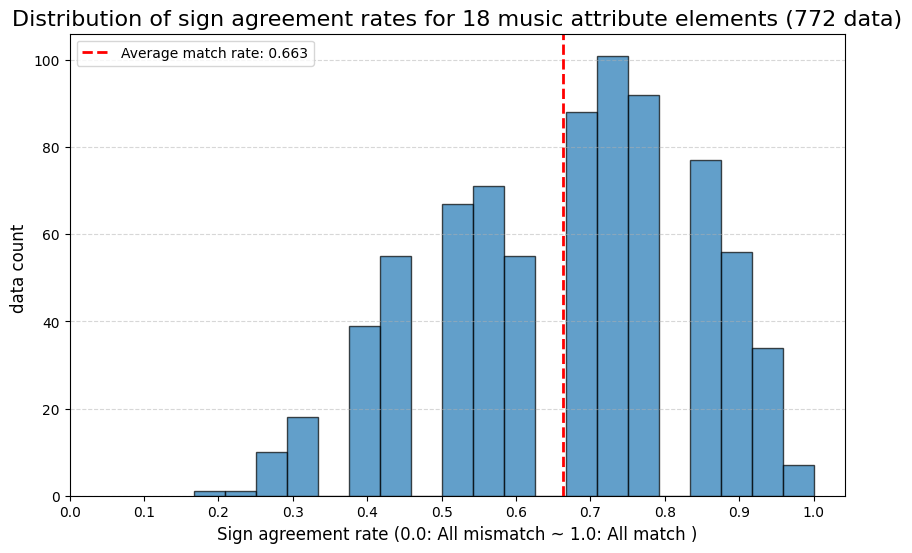

'\nx_true_Valence = (np.float32(Valence_correct_coordinate[:,0]))#.reshape(-1, 1)\ny_true_Valence = np.squeeze(np.float32(Valence_encode.detach().numpy()))#.reshape(-1, 1)\nplt.figure(figsize=(5,4))\nplt.scatter(x_true_Valence.reshape(-1, 1), predict_Valence_V_c_a18.reshape(-1, 1).cpu().detach().numpy(), s=10, alpha=0.6)\nplt.xlabel("x : Valence")\nplt.ylabel("y : Encoder predict")\nplt.title("Scatter plot x vs y")\nplt.show()\n'

In [78]:
# 評価
# モデルのクラスをロードする！
INPUT_SIZE = 1 # x : Valence
HIDDEN_SIZE = 32 # 隠れ層のユニット数（調整可能）
OUTPUT_SIZE = 18    # y : Encoder predict
model_V_c_a18 = Valence_CtoA18(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE).to(device)
#model_V_c_a18.load_state_dict(torch.load('Valence_c_a18_checkpoint.pt')['model_state_dict']) # 音楽属性値の値そのまま
model_V_c_a18.load_state_dict(torch.load("Valence_c_a18_thresholds_checkpoint.pt")['model_state_dict']) # 音楽属性値 - 閾値
# model_V_c_a18 = Valence_CtoA18_withArousal(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE).to(device) # 2→18
# model_V_c_a18.load_state_dict(torch.load("Valence_c_a18_thresholds_A_checkpoint.pt")['model_state_dict']) 
# ニューラルネットワーク
predict_Valence_V_c_a18 = (model_V_c_a18(th.from_numpy(Vc).to(torch.float32).unsqueeze(1).to(device)))#.reshape(-1, 1)


print('実際の音楽属性値の精度')
# -------------------
# cos類似度
import numpy as np
def cos_sim(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

Valence_c_a1_all  = 0.0
for i in range(772):
    Valence_c_a1_all0 = cos_sim((np.float32(Va_18))[i,:] , predict_Valence_V_c_a18.cpu().detach().numpy()[i,:]) # .reshape(-1, 1)なし(2→1次元)
    if np.isnan(Valence_c_a1_all0) ==  False: 
        Valence_c_a1_all = Valence_c_a1_all + Valence_c_a1_all0
    '''
    if i%10:
        print("正解音楽属性値" + str(np.float32(Va_18)[i,:]))
        print("予測音楽属性値" + str(predict_Valence_V_c_a18.cpu().detach().numpy()[i,:]))
        print("-------")
    '''
#print(score)
print(Valence_c_a1_all / 772.0) #len(Valence_true))
#print(cos_sim(np.squeeze(np.float32(Va_18)) , np.squeeze(predict_Valence_V_c_a18.reshape(-1, 1).cpu().detach().numpy()))) # 一気にcos類似度を計算

# -------------------
# ピアソン相関係数
print(np.float32(predict_Valence_V_c_a18.cpu().detach().numpy()).shape)
from scipy.stats import pearsonr, spearmanr
pearson_r =0.0#[]
pearson_p =0.0#[][]
spearman_r =0.0#[][]
spearman_p =0.0#[][]
for V_data in range(772):
    pearson_r0, pearson_p0 = pearsonr(np.squeeze(Va_18[V_data,:]), np.squeeze(np.float32(predict_Valence_V_c_a18.cpu().detach().numpy())[V_data,:]))
    spearman_r0, spearman_p0 = spearmanr((Va_18).reshape(-1, 1), (np.float32(predict_Valence_V_c_a18.reshape(-1, 1).cpu().detach().numpy())))  
    if np.isnan(pearson_r0) ==  False:
        pearson_r = pearson_r+pearson_r0 #pearson_r.append(pearson_r0)
    if np.isnan(pearson_p0) ==  False:
        pearson_p = pearson_p+pearson_p0 #pearson_p.append(pearson_p0)
    if np.isnan(spearman_r0) ==  False:
        spearman_r = spearman_r + spearman_r0 #spearman_r.append(spearman_r0)
    if np.isnan(spearman_p0) ==  False:
        spearman_p = spearman_p + spearman_p0 #spearman_p.append(spearman_p0)
print("Pearson r:", pearson_r/772.0, "p:", pearson_p/772.0)
print("Spearman rho:", spearman_r/772.0, "p:", spearman_p/772.0)



# -------------------
print('\n')
print('(実際の音楽属性値 - 閾値)の予測の精度：正負が一致しており、値の大きさはどれぐらい近いか?')
# 正負の一致度：np.sign()...正: 1.0, 負: -1.0, ゼロ: 0.0 
# sign_true = np.sign(np.float32(Va_18))
# sign_predict = np.sign(predict_Valence_V_c_a18.cpu().detach().numpy())
sign_true = np.sign(np.float32(Va_18)- np.float32(thresholds.repeat(772,1).T[:,Valence_feature_index]))
sign_predict = np.sign(predict_Valence_V_c_a18.cpu().detach().numpy()- np.float32(thresholds.repeat(772,1).T[:,Valence_feature_index]))

match_counts = np.sum(sign_true == sign_predict, axis=1)

# (D) 各データの一致率を算出（0.0 〜 1.0）
match_ratios = match_counts / 18
print(f"\n最初の5つのデータの一致数（18要素中）: {match_counts[:5]}")
print(f"最初の5つのデータの一致率: {match_ratios[:5]}")
plt.figure(figsize=(10, 6))

# ヒストグラム
# bin=20で、0.0から1.0までを20分割して、データがどの割合に集中しているかを見る
plt.hist(match_ratios, bins=20, edgecolor='black', alpha=0.7, color='#1f77b4')
plt.title('Distribution of sign agreement rates for 18 music attribute elements (772 data)', fontsize=16)
plt.xlabel('Sign agreement rate (0.0: All mismatch ~ 1.0: All match )', fontsize=12)
plt.ylabel('data count ', fontsize=12)
plt.grid(axis='y', alpha=0.5, linestyle='--')
plt.axvline(np.mean(match_ratios), color='red', linestyle='dashed', linewidth=2, label=f'Average match rate: {np.mean(match_ratios):.3f}')
plt.legend()
plt.xticks(np.arange(0, 1.1, 0.1)) # x軸の目盛りを0.1刻みに
plt.show()


# -------------------
# 可視化
'''
from matplotlib import pyplot as  plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import numpy as np
#plt.figure(figsize=(50,10))
#plt.subplot(1,2,1)
#sc = StandardScaler() 
plt.figure(figsize=(50,10))
plt.plot(Va_18.reshape(-1, 1),ls="--",  color="green") #sns.scatterplot(data = Q1_4average[0] , color="green")
plt.plot(predict_Valence_V_c_a18.reshape(-1, 1).cpu().detach().numpy(), color="green")
#plt.plot((np.float32(Valence_encode.detach().numpy())).reshape(-1, 1) - predict_Valence_encode.reshape(-1, 1).cpu().detach().numpy(), color="red")
plt.plot(Vc.reshape(-1, 1) , color="red")
plt.xlabel('100 music attribute')
plt.ylabel('threshold 0 or 1')
plt.show()
'''
# ---- 1. 可視化：散布図 ----
'''
x_true_Valence = (np.float32(Valence_correct_coordinate[:,0]))#.reshape(-1, 1)
y_true_Valence = np.squeeze(np.float32(Valence_encode.detach().numpy()))#.reshape(-1, 1)
plt.figure(figsize=(5,4))
plt.scatter(x_true_Valence.reshape(-1, 1), predict_Valence_V_c_a18.reshape(-1, 1).cpu().detach().numpy(), s=10, alpha=0.6)
plt.xlabel("x : Valence")
plt.ylabel("y : Encoder predict")
plt.title("Scatter plot x vs y")
plt.show()
'''


### EMOPIA_Arousal

In [35]:
# データセット
from sklearn.model_selection import train_test_split # 学習用・テスト用データに分割 
from torch.utils.data import TensorDataset, DataLoader
# 学習データセット
# Arousal
Ac = np.float32(Arousal_correct_coordinate[:,1])
# Valenceの要素も加える
#Ac = np.float32(Arousal_correct_coordinate)
Aa_18 = np.float32((Arousal_correct_attribute[:,feature_index])[:,Arousal_feature_index])
train_Ac , valid_Ac , train_Aa_18 , valid_Aa_18= train_test_split(Ac,Aa_18,test_size=0.2, random_state=0)
# データローダ
batch_size = 16
train_dataset_A_c_a18 = TensorDataset(th.from_numpy(train_Ac).unsqueeze(1), th.from_numpy(train_Aa_18))
valid_dataset_A_c_a18 = TensorDataset(th.from_numpy(valid_Ac).unsqueeze(1), th.from_numpy(valid_Aa_18))
test_dataset_A_c_a18 = TensorDataset(th.from_numpy(Ac).unsqueeze(1), th.from_numpy(Aa_18))
train_dataloader_A_c_a18 = DataLoader(train_dataset_A_c_a18,batch_size=batch_size,shuffle=True,)
valid_dataloader_A_c_a18 = DataLoader(valid_dataset_A_c_a18,batch_size=batch_size,shuffle=True,)
test_dataloader_A_c_a18 = DataLoader(test_dataset_A_c_a18,batch_size=batch_size,shuffle=False,)


In [51]:
# 学習
num_epochs = 1_000 # 最大エポック数
early_stopping_patience = 10 # 改善が見られなかった場合に停止する Early Stopping のエポック数
device = computing_device() # 学習に使うデバイス

# モデル
INPUT_SIZE = 1 # x : Valence
HIDDEN_SIZE = 32 # 隠れ層のユニット数（調整可能）
OUTPUT_SIZE = 18    # y : Encoder predict
model_A_c_a18 = Arousal_CtoA18(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE).to(device)
#model_A_c_a18 = Arousal_CtoA18_withValence(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE).to(device) # 2→18

criterion = nn.MSELoss() # 損失関数
#criterion = MultiThresholdSignLoss(thresholds=thresholds.T[:,Arousal_feature_index],device=device ,penalty_weight=5.0) # 5, 70,30
optimizer_A_c_a18 = optim.Adam(model_A_c_a18.parameters()) # LEARNING_RATE = 0.001 # オプティマイザ
checkpoint_path_A_c_a18 = "Arousal_c_a18_checkpoint.pt" # 途中結果を記録するパス
#checkpoint_path_A_c_a18 = "Arousal_c_a18_thresholds_checkpoint.pt" # 音楽属性値 - 閾値 のペナルティ
#heckpoint_path_A_c_a18 = "Arousal_c_a18_thresholds_V_checkpoint.pt" # 音楽属性値 - 閾値　のペナルティ + Arousalの値
  

# 学習する
train_CtoA18(
    model_A_c_a18,
    train_dataloader_A_c_a18,
    valid_dataloader_A_c_a18,
    device,
    criterion,
    optimizer_A_c_a18,
    num_epochs,
    early_stopping_patience,
    checkpoint_path_A_c_a18,
)

# ベストなモデルをロードする
checkpoint_A_c_a18 = torch.load(checkpoint_path_A_c_a18)
model_A_c_a18.load_state_dict(checkpoint_A_c_a18["model_state_dict"])
best_epoch_A_c_a18 = checkpoint_A_c_a18["epoch"]
best_val_loss_A_c_a18 = checkpoint_A_c_a18["loss"]

# テストデータを評価する
test_loss_A_c_a18 = evaluate_CtoA18(
    model_A_c_a18,
    test_dataloader_A_c_a18,
    device,
    criterion,
)
print(f"Epoch: {best_epoch_A_c_a18}, Validation Loss: {best_val_loss_A_c_a18:.5f}")
print(f"Test Set Evaluation - Loss: {test_loss_A_c_a18:.5f}")

Device: cuda:2,3
Epoch [1/1000], Training Loss: 230.14060
Epoch [1/1000], Validation Loss: 220.99368
Epoch [2/1000], Training Loss: 167.24319
Epoch [2/1000], Validation Loss: 86.99526
Epoch [3/1000], Training Loss: 26.11629
Epoch [3/1000], Validation Loss: 5.44543
Epoch [4/1000], Training Loss: 5.42421
Epoch [4/1000], Validation Loss: 4.73594
Epoch [5/1000], Training Loss: 4.90622
Epoch [5/1000], Validation Loss: 4.47870
Epoch [6/1000], Training Loss: 4.68338
Epoch [6/1000], Validation Loss: 4.07275
Epoch [7/1000], Training Loss: 4.35796
Epoch [7/1000], Validation Loss: 3.84854
Epoch [8/1000], Training Loss: 4.20963
Epoch [8/1000], Validation Loss: 3.75678
Epoch [9/1000], Training Loss: 4.07260
Epoch [9/1000], Validation Loss: 3.77838
Epoch [10/1000], Training Loss: 3.95933
Epoch [10/1000], Validation Loss: 3.65165
Epoch [11/1000], Training Loss: 3.99097
Epoch [11/1000], Validation Loss: 3.50234
Epoch [12/1000], Training Loss: 3.84840
Epoch [12/1000], Validation Loss: 3.53237
Epoch [13

/tmp/ipykernel_3451549/3912245457.py:20: RuntimeWarning: invalid value encountered in float_scalars
  return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))


0.9959903966663475
(1064, 18)
Pearson r: 0.99569024287842 p: 3.3918150346411843e-10
Spearman rho: 0.9272273016140374 p: 0.0
(実際の音楽属性値 - 閾値)の予測の精度：正負が一致しており、値の大きさはどれぐらい近いか?

最初の5つのデータの一致数（18要素中）: [13 13 13 14 14]
最初の5つのデータの一致率: [0.72222222 0.72222222 0.72222222 0.77777778 0.77777778]


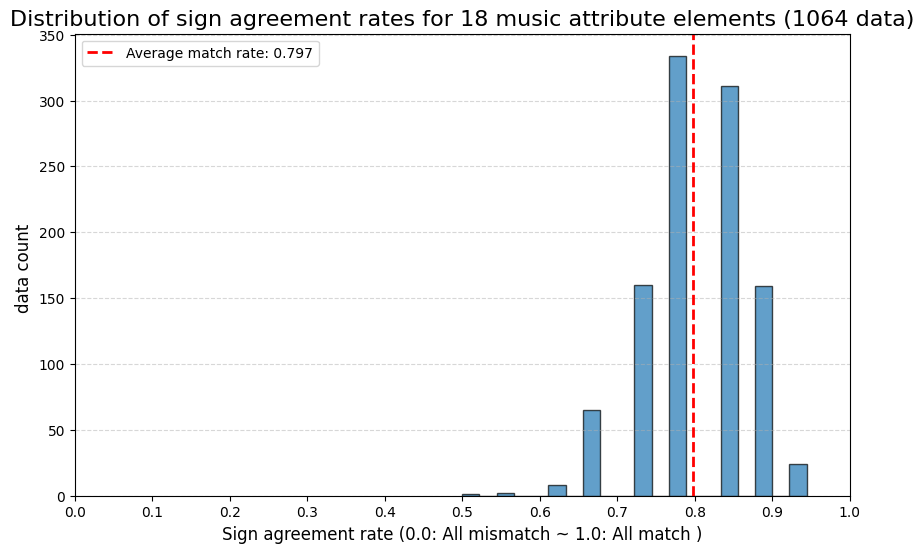

In [52]:
# 評価
# モデルのクラスをロードする！
INPUT_SIZE = 1 # x : Valence
HIDDEN_SIZE = 32# 隠れ層のユニット数（調整可能）
OUTPUT_SIZE = 18    # y : Encoder predict
model_A_c_a18 = Arousal_CtoA18(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE).to(device)
model_A_c_a18.load_state_dict(torch.load('Arousal_c_a18_checkpoint.pt')['model_state_dict'])
# model_A_c_a18.load_state_dict(torch.load("Arousal_c_a18_thresholds_checkpoint.pt")['model_state_dict']) # 音楽属性値 - 閾値
#model_A_c_a18 = Arousal_CtoA18_withValence(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE).to(device) # 2→18
#model_A_c_a18.load_state_dict(torch.load("Arousal_c_a18_thresholds_V_checkpoint.pt")['model_state_dict']) 
#
# ニューラルネットワーク
predict_Arousal_A_c_a18 = (model_A_c_a18(th.from_numpy(Ac).to(torch.float32).unsqueeze(1).to(device)))#.reshape(-1, 1)


# -------------------
# cos類似度
import numpy as np
def cos_sim(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

Arousal_c_a1_all  = 0.0
for i in range(1064):
    Arousal_c_a1_all0 = cos_sim((np.float32(Aa_18))[i,:] , predict_Arousal_A_c_a18.cpu().detach().numpy()[i,:]) # .reshape(-1, 1)なし(2→1次元)
    if np.isnan(Arousal_c_a1_all0) ==  False: 
        Arousal_c_a1_all = Arousal_c_a1_all + Arousal_c_a1_all0
    '''
    if i%10:
        print("正解音楽属性値" + str(np.float32(Aa_18)[i,:]))
        print("予測音楽属性値" + str(predict_Valence_V_c_a18.cpu().detach().numpy()[i,:]))
        print("-------")
    '''
#print(score)
print(Arousal_c_a1_all / 1064.0) #len(Valence_true))
#print(cos_sim(np.squeeze(np.float32(Va_18)) , np.squeeze(predict_Valence_V_c_a18.reshape(-1, 1).cpu().detach().numpy()))) # 一気にcos類似度を計算

# -------------------
# ピアソン相関係数
print(np.float32(predict_Arousal_A_c_a18.cpu().detach().numpy()).shape)
from scipy.stats import pearsonr, spearmanr
pearson_r =0.0#[]
pearson_p =0.0#[][]
spearman_r =0.0#[][]
spearman_p =0.0#[][]
for A_data in range(1064):
    pearson_r0, pearson_p0 = pearsonr(np.squeeze(Aa_18[A_data,:]), np.squeeze(np.float32(predict_Arousal_A_c_a18.cpu().detach().numpy())[A_data,:]))
    spearman_r0, spearman_p0 = spearmanr((Aa_18).reshape(-1, 1), (np.float32(predict_Arousal_A_c_a18.reshape(-1, 1).cpu().detach().numpy())))  
    if np.isnan(pearson_r0) ==  False:
        pearson_r = pearson_r+pearson_r0 #pearson_r.append(pearson_r0)
    if np.isnan(pearson_p0) ==  False:
        pearson_p = pearson_p+pearson_p0 #pearson_p.append(pearson_p0)
    if np.isnan(spearman_r0) ==  False:
        spearman_r = spearman_r + spearman_r0 #spearman_r.append(spearman_r0)
    if np.isnan(spearman_p0) ==  False:
        spearman_p = spearman_p + spearman_p0 #spearman_p.append(spearman_p0)
print("Pearson r:", pearson_r/1064.0, "p:", pearson_p/1064.0)
print("Spearman rho:", spearman_r/1064.0, "p:", spearman_p/1064.0)

# -------------------
# -------------------
print('(実際の音楽属性値 - 閾値)の予測の精度：正負が一致しており、値の大きさはどれぐらい近いか?')
# 正負の一致度：np.sign()...正: 1.0, 負: -1.0, ゼロ: 0.0 
sign_true = np.sign(np.float32(Aa_18) - np.float32(thresholds.repeat(1064,1).T[:,Arousal_feature_index]))
sign_predict = np.sign(predict_Arousal_A_c_a18.cpu().detach().numpy() - np.float32(thresholds.repeat(1064,1).T[:,Arousal_feature_index]))
match_counts = np.sum(sign_true == sign_predict, axis=1)

# (D) 各データの一致率を算出（0.0 〜 1.0）
match_ratios = match_counts / 18
print(f"\n最初の5つのデータの一致数（18要素中）: {match_counts[:5]}")
print(f"最初の5つのデータの一致率: {match_ratios[:5]}")
plt.figure(figsize=(10, 6))

# ヒストグラム
# bin=20で、0.0から1.0までを20分割して、データがどの割合に集中しているかを見る
plt.hist(match_ratios, bins=20, edgecolor='black', alpha=0.7, color='#1f77b4')
plt.title('Distribution of sign agreement rates for 18 music attribute elements (1064 data)', fontsize=16)
plt.xlabel('Sign agreement rate (0.0: All mismatch ~ 1.0: All match )', fontsize=12)
plt.ylabel('data count ', fontsize=12)
plt.grid(axis='y', alpha=0.5, linestyle='--')
plt.axvline(np.mean(match_ratios), color='red', linestyle='dashed', linewidth=2, label=f'Average match rate: {np.mean(match_ratios):.3f}')
plt.legend()
plt.xticks(np.arange(0, 1.1, 0.1)) # x軸の目盛りを0.1刻みに
plt.show()


### 実際のEMOPIA(**audio**データ)の座標をQ1~Q4でプロット

* youtubeで取得したEMOPIAデータ (mp3形式)
* 二次元配列：インデックス指定で行を取得できる

In [19]:
import csv
with open('EMOPIA_mp3_Q1_muse_vgg.csv') as f1:
    reader1 = csv.reader(f1)
    l1 = [row for row in reader1]
    l_T1 = [list(x) for x in zip(*l1)] # 転置
    x1 = l_T1[:][1]
    y1 = l_T1[:][2]
with open('EMOPIA_mp3_Q2_muse_vgg.csv') as f2:
    reader2 = csv.reader(f2)
    l2 = [row for row in reader2]
    l_T2 = [list(x) for x in zip(*l2)] # 転置
    x2 = l_T2[:][1]
    y2 = l_T2[:][2]
with open('EMOPIA_mp3_Q3_muse_vgg.csv') as f3:
    reader3 = csv.reader(f3)
    l3 = [row for row in reader3]
    l_T3 = [list(x) for x in zip(*l3)] # 転置
    x3 = l_T3[:][1]
    y3 = l_T3[:][2]
with open('EMOPIA_mp3_Q4_muse_vgg.csv') as f4:
    reader4 = csv.reader(f4)
    l4 = [row for row in reader4]
    l_T4 = [list(x) for x in zip(*l4)] # 転置
    x4 = l_T4[:][1]
    y4 = l_T4[:][2]
print(y4[2][1:-1])

-0.13500166


/tmp/ipykernel_3329645/3002641039.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Text(0.5, 1.0, 'EMOPIA_youtube_Audio_muse_vgg')

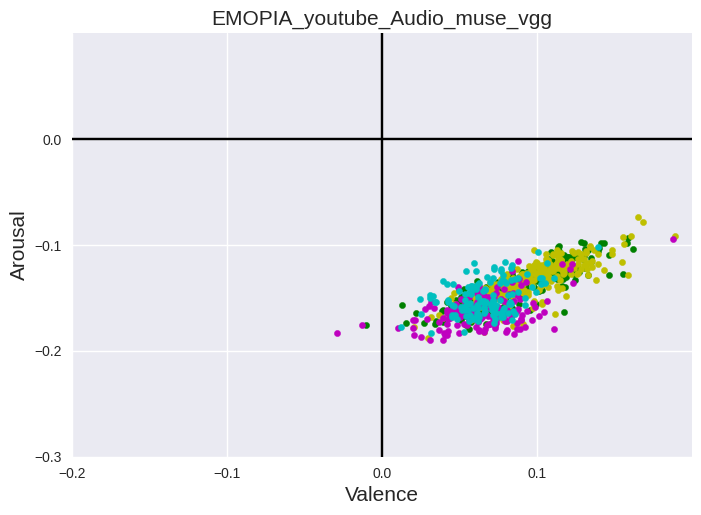

In [21]:
from matplotlib import pyplot as  plt
import seaborn as sns
#import japanize_matplotlib
import numpy as np

plt.style.use('seaborn')
#plt.rcParams['font.family'] = 'IPAexGothic'  

#n = 0
#plt.scatter(a,b)
color_list = [ "g", "y" ,"m", "c"] #, "k"]
for n in range(len(x1)-1):
    plt.scatter(float(x1[n+1][1:-1]), float(y1[n+1][1:-1]), 20 ,color_list[0])
for n in range(len(x2)-1):
    plt.scatter(float(x2[n+1][1:-1]), float(y2[n+1][1:-1]), 20 ,color_list[1])
for n in range(len(x3)-1):
    plt.scatter(float(x3[n+1][1:-1]), float(y3[n+1][1:-1]), 20 ,color_list[2])
for n in range(len(x4)-1):
    plt.scatter(float(x4[n+1][1:-1]), float(y4[n+1][1:-1]), 20 ,color_list[3])

plt.xlim(-0.2 , 0.2) # (3)x軸の表示範囲
plt.ylim(-0.3 , 0.1) # (4)y軸の表示範囲
plt.xticks(np.arange(-0.2, 0.2 ,0.10))
plt.yticks(np.arange(-0.3, 0.1 , 0.10)) # plt.tick_params(width = 0.005, length = 0.005)

plt.xlabel('Valence' , fontsize=15)
plt.ylabel('Arousal' , fontsize=15)
plt.hlines(0,-1,1, "k",linestyle="-")
plt.vlines(0,-1,1, "k", linestyle="-")
plt.title('EMOPIA_youtube_Audio_muse_vgg', fontsize=15)

#plt.text(-0.275, -0.123, "第３章限" , size 

In [2]:
torch.cuda.is_available()

True

In [5]:
! which python

/home/moyu/.conda/envs/music/bin/python


## EMOPIAを用いた入力感情

1. Valence  
→ BEST：**EMOPIA_Valence_c_a18_model.pt**
* Valence_c_a18_checkpoint.pt
* Valence_c_a18_thresholds_checkpoint.pt
* Valence_c_a18_thresholds_A_checkpoint.pt  
----------------------------------  
2. Arousal  
→ BEST：**EMOPIA_Arousal_c_a18_model.pt**　(EMOPIA_Arousal_c_a18_model_2.pt)  
* Arousal_c_a18_checkpoint.pt
* Arousal_c_a18_thresholds_checkpoint.pt
* Arousal_c_a18_thresholds_V_checkpoint.pt

* 関数と学習済みモデルの読み込み

In [1]:
import random
import numpy as np
import torch as th
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

In [80]:
def computing_device(force=None):
    """環境によって計算に使うデバイスを切り替える関数"""
    if force is not None:
        return force
    if torch.cuda.is_available():
        return "cuda:2,3"
    if torch.backends.mps.is_available():
        return "mps"
    return "cpu"

class Valence_CtoA18(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Valence_CtoA18, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size * 2) 
        self.fc3 = nn.Linear(hidden_size * 2 , hidden_size)
        self.fc4 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU() #nn.LeakyReLU(0.01) 
        self.fc5 = nn.Linear(hidden_size * 2, hidden_size * 4) 
        self.fc6 = nn.Linear(hidden_size * 4 , hidden_size * 2)
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        #x = self.relu(self.fc5(x))
        #x = self.relu(self.fc6(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        
        
        return x
    
class Arousal_CtoA18(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Arousal_CtoA18, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size * 2) 
        self.fc3 = nn.Linear(hidden_size * 2 , hidden_size)
        self.fc4 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU() # nn.LeakyReLU(0.01)
        self.fc5 = nn.Linear(hidden_size * 2, hidden_size * 4) 
        self.fc6 = nn.Linear(hidden_size * 4 , hidden_size * 2)
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        #x = self.relu(self.fc5(x))
        #x = self.relu(self.fc6(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        #x = self.relu(self.fc4(x))
        return x

class Valence_CtoA18_withArousal(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Valence_CtoA18_withArousal, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size * 2) 
        self.fc3 = nn.Linear(hidden_size * 2 , hidden_size)
        self.fc4 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU() # nn.LeakyReLU(0.01)
        self.lrelu = nn.LeakyReLU(0.01)
        # Dropout層
        self.aux_dropout = nn.Dropout(p=0.5)  # x2専用のDropout層 (確率を高く設定=よく消える)
        # バイアス層：input_size = 1
        self.aux_net = nn.Linear(input_size, output_size, bias=False) # バイアス項として働く,bias=Falseにすることで純粋な係数に
        with torch.no_grad(): # もしx2の影響を最初から極小にしておきたい場合、重みを小さく初期化する
            self.aux_net.weight.mul_(0.01) # 重みを0.01倍にする
        
    def forward(self, x):
        # Dropout層
        '''
        x2_dropped = self.aux_dropout(torch.squeeze(x)[:,1]) # x2 にだけ Dropout をかける [32]に次元数を減らす
        x_cat = torch.cat([torch.unsqueeze(torch.squeeze(x)[:,0],1), torch.unsqueeze(x2_dropped,1)], dim=1) # 結合してネットワークへ [32,1]
        x = self.relu(self.fc1(x_cat)
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        ''' 
        # バイアス層 
        x1 = torch.unsqueeze(torch.squeeze(x)[:,0],1)
        x2 = torch.unsqueeze(torch.squeeze(x)[:,1],1)
        x1 = self.relu(self.fc1(x1))
        x1 = self.relu(self.fc2(x1))
        x1 = self.relu(self.fc3(x1))
        main_out = self.fc4(x1) # main_out
        aux_out = self.aux_net(x2)
        x = self.relu(main_out + aux_out) # 足し合わせてから、最終的な活性化関数(ReLU)を通す
        
        return x

class Arousal_CtoA18_withValence(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Arousal_CtoA18_withValence, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size * 2) 
        self.fc3 = nn.Linear(hidden_size * 2 , hidden_size)
        self.fc4 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU() # nn.LeakyReLU(0.01)
        self.lrelu = nn.LeakyReLU(0.01)
        self.aux_dropout = nn.Dropout(p=0.5)  # x2専用のDropout層 (確率を高く設定=よく消える)
        # バイアス層：input_size = 1
        self.aux_net = nn.Linear(input_size, output_size, bias=False) # バイアス項として働く,bias=Falseにすることで純粋な係数に
        with torch.no_grad(): # もしx2の影響を最初から極小にしておきたい場合、重みを小さく初期化する
            self.aux_net.weight.mul_(0.01) # 重みを0.01倍にする
        
    def forward(self,  x):
        '''
        x1_dropped = self.aux_dropout(torch.squeeze(x)[:,0]) # x2 にだけ Dropout をかける
        x_cat = torch.cat([torch.unsqueeze(torch.squeeze(x)[:,0],1), torch.unsqueeze(x2_dropped,1)], dim=1) # 結合してネットワークへ
        x = self.relu(self.fc1(x_cat))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        '''
        # バイアス層 
        x1 = torch.unsqueeze(torch.squeeze(x)[:,0],1)
        x2 = torch.unsqueeze(torch.squeeze(x)[:,1],1)
        x2 = self.relu(self.fc1(x2))
        x2 = self.relu(self.fc2(x2))
        x2 = self.relu(self.fc3(x2))
        main_out = self.fc4(x2) # main_out
        aux_out = self.aux_net(x1)
        #x = self.relu(main_out + aux_out) # 足し合わせてから、最終的な活性化関数(ReLU)を通す
        x = (main_out + aux_out) 
        
        return x    

def train_CtoA18(
    model,
    train_dataloader,
    valid_dataloader,
    device,
    criterion,
    optimizer,
    num_epochs,
    early_stopping_patience,
    checkpoint_path="checkpoint.pt",
):
    """学習に使う関数"""
    print(f"Device: {device}")

    # Early Stopping に使うカウンタ
    early_stopping_patience_counter = 0
    # Early Stopping に使う検証データに対する損失
    early_stopping_best_val_loss = float("inf")

    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss = 0.0
        for coordinate, attribute in train_dataloader:
            # ラベルは使用しない
            inputs = coordinate.to(device)
            true_output = attribute.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            loss = criterion(outputs, true_output)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch [{epoch}/{num_epochs}], Training Loss: {running_loss / len(train_dataloader):.5f}")

        val_loss = evaluate_CtoA18(model, valid_dataloader, device, criterion)
        print(f"Epoch [{epoch}/{num_epochs}], Validation Loss: {val_loss:.5f}")

        if early_stopping_patience == -1:
            continue

        if val_loss < early_stopping_best_val_loss:
            early_stopping_best_val_loss = val_loss
            early_stopping_patience_counter = 0
            # ベストなモデルとして Checkpoint を更新する
            checkpoint_params = {
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "loss": val_loss,
            }
            torch.save(
                checkpoint_params,
                checkpoint_path,
            )
        else:
            early_stopping_patience_counter += 1

        if early_stopping_patience_counter >= early_stopping_patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break

    print("Training Finished")
    
 
def evaluate_CtoA18(model, dataloader, device, criterion):
    """評価に使う関数"""
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for coordinate, attribute in dataloader:
            inputs = coordinate.to(device)
            true_output = attribute.to(device)

            outputs = model(inputs)

            loss = criterion(outputs, true_output)
            running_loss += loss.item()

    average_loss = running_loss / len(dataloader)

    return average_loss


# thresholdsを引き、正負が異なってたらペナルティ
class MultiThresholdSignLoss(nn.Module):
    def __init__(self, thresholds,device ,penalty_weight=5.0):
        super().__init__()
        
        self.penalty_weight = penalty_weight # 正負が不一致の場合のペナルティ倍率
        self.base_loss = nn.MSELoss(reduction='none') 
        self.device = device
        
        if not isinstance(thresholds, torch.Tensor): # 閾値をTensor化し、学習対象外(buffer)として登録、GPU/CPU移動時に自動でついてくる
            thresholds = torch.tensor(thresholds, dtype=torch.float32).to(device)
        self.register_buffer('thresholds', thresholds)
        

    def forward(self, pred, target):
        # 1. MSELoss
        loss = self.base_loss(pred, target) #shape: (Batch, 18)
        
        # 2. 閾値を引いた「相対値」を計算
        pred_shifted = pred - self.thresholds
        target_shifted = target - self.thresholds
        
        # 3. 正負不一致の判定：掛け算してマイナスなら符号が逆 (True/False)
        sign_mismatch = (pred_shifted * target_shifted) < 0
        
        # 4. ペナルティの適用：不一致なら loss * penalty_weight、一致なら loss * 1.0
        weights = torch.ones_like(loss)
        weights[sign_mismatch] = self.penalty_weight
        
        weighted_loss = loss * weights
        
        # 5. 全体の平均を返す
        return weighted_loss.mean()


In [2]:
Valence_feature_index = [1, 2, 3, 5, 20, 22, 25, 26, 35, 37, 40, 41, 42, 43, 44, 45, 49, 57]
Arousal_feature_index = [62, 63, 64, 67, 68, 69, 70, 71, 73, 75, 77, 81, 84, 85, 87, 92, 95, 99]

* 座標値に対応する音楽属性値(それぞれ18属性)  
→ 学習済みモデルを使用

In [84]:
INPUT_SIZE = 1 # x : Valence
HIDDEN_SIZE = 32# 隠れ層のユニット数（調整可能）
OUTPUT_SIZE = 18    # y : Encoder predict
device = computing_device() # 学習に使うデバイス

# 入力：座標
xy_coordinate = th.tensor([[0.4,0.5],[-0.4,0.5],[-0.4,-0.5],[0.4,-0.5]])
# 出力：音楽属性値
music_attribute_18_2 = th.zeros(4,100)

# Valence
model_V_c_a18 = Valence_CtoA18(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE).to(device)
model_V_c_a18.load_state_dict(torch.load("EMOPIA_Valence_c_a18_model.pt")['model_state_dict']) # 音楽属性値 - 閾値
# Arousal
model_A_c_a18 = Arousal_CtoA18(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE).to(device) # 2→18
model_A_c_a18.load_state_dict(torch.load("EMOPIA_Arousal_c_a18_model.pt")['model_state_dict']) 

# Valence：predict
predict_Valence_V_c_a18  = model_V_c_a18(xy_coordinate[:,0].to(torch.float32).unsqueeze(1).to(device))
music_attribute_18_2[:,Valence_feature_index] = predict_Valence_V_c_a18.cpu().detach()
# Arousal
predict_Arousal_A_c_a18 = model_A_c_a18(xy_coordinate[:,1].to(torch.float32).unsqueeze(1).to(device))
music_attribute_18_2[:,Arousal_feature_index] = predict_Arousal_A_c_a18.cpu().detach()


th.save(music_attribute_18_2,'../../../../../../../input_emotion_*/input_emotion_18_2_EMOPIA.pt')
print(music_attribute_18_2[0,:])

tensor([ 0.0000e+00,  6.9195e-02,  0.0000e+00,  1.1992e-01,  0.0000e+00,
         6.2868e-02,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         5.9664e-01,  7.4280e-02,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.5663e-02,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.1230e-01,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  3.4767e-01,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  1.5995e-01,  3.5478e-02,  1.2288e-01,
         0.0000e+00,  0.0000e+00,  2.9672e-01,  3.8

## (確認)

In [14]:
V_A_feature_index = [1, 2, 3, 5, 20, 22, 25, 26, 35, 37, 40, 41, 42, 43, 44, 45, 49, 57 , 62, 63, 64, 67, 68, 69, 70, 71, 73, 75, 77, 81, 84, 85, 87, 92, 95, 99]

#thresholds = th.from_numpy(np.load('/home/moyu/program/Diffusion-LM-on-Symbolic-Music-Generation/improved-diffusion/emogen/data/threshold.npy', allow_pickle=True)).T
thresholds_weight_100 = (th.load('/home/moyu/program/Diffusion-LM-on-Symbolic-Music-Generation/improved-diffusion/emogen/std_mean.pt'))[0,:].float().unsqueeze(dim=1).T.numpy()
weight_same_traindata_E = np.load('/home/moyu/program/Diffusion-LM-on-Symbolic-Music-Generation/improved-diffusion/symbolic_music/scripts/russell_train_weight.npz')['arr_0']
weight_same_traindata_D = np.load('/home/moyu/program/Diffusion-LM-on-Symbolic-Music-Generation/improved-diffusion/symbolic_music/scripts/DEAM_train_weight.npz')['arr_0']
print(weight_same_traindata_E.shape)
print(thresholds.T.shape)

thresholds = np.load('/home/moyu/program/Diffusion-LM-on-Symbolic-Music-Generation/improved-diffusion/emogen/data/threshold.npy', allow_pickle=True)
mask18_2 = np.zeros_like(thresholds)
number_a18_2 = [1, 2, 3, 5, 20, 22, 25, 26, 35, 37, 40, 41, 42, 43, 44, 45, 49, 57, 62, 63, 64, 67, 68, 69, 70, 71, 73, 75, 77, 81, 84, 85, 87, 92, 95, 99] # 音楽属性値18*2
mask18_2[number_a18_2] = 1.0 #100→36
thresholds_rep= (th.from_numpy(thresholds * mask18_2).T.shape)
print(thresholds_rep)
    

(100,)
(1, 100)
torch.Size([1, 100])


In [85]:
T_input = np.load('/home/moyu/program/Diffusion-LM-on-Symbolic-Music-Generation/datasets/midi/giant_midi_piano/traindata_attributeQ1_4.npy')
T_input = T_input * thresholds_weight_100  ### 入力2. 100_重みなし 入力3,4でも必要
D_input = th.load('../../../../../../../input_emotion_*/input_emotion_18_2_DEAM.pt').unsqueeze(0)
E_input = th.load('../../../../../../../input_emotion_*/input_emotion_18_2_EMOPIA.pt').unsqueeze(0)
print('Traindata = ' + str(T_input[0][V_A_feature_index]))
print('DEAMdata = ' + str(D_input[:,0]))
print('EMOPIAdata = ' + str(E_input[:,0]))

torch.Size([1, 100])
